# Imports & Setups

In [1]:
# !pip install --upgrade numpy matplotlib seaborn pandas scipy scikit-learn statsmodels pmdarima lightgbm

In [2]:
from my_functions.df_exploration import *
from my_functions.tsa.time_series_analysis import *
from my_functions.machine_learning import trainning_sets, train_cv

from my_functions.tsa.heteroskedasticity import Heteroskedasticity
from scipy.stats import boxcox, uniform
from scipy.special import inv_boxcox

from pmdarima import AutoARIMA, ARIMA, model_selection, datasets, auto_arima

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from my_functions.tsa.cv_extensions.montecarlo_cv import MonteCarloCV
from my_functions.tsa.metrics import *

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
plot_fig_args = {
    'width' : 16 ,
    'height' : 4,
    'dpi' : 100 
    }

plot_seasonal_decompose_fig_args = {
    'width' : 20 ,
    'height' : 10,
    'dpi' : 100 
    }

plot_tsa_fig_args = {
    'width' : 12 ,
    'height' : 8,
    'dpi' : 100 
    }

# Load Data

Le data set contient :
	- 999 lignes et 17 colonnes.
	- 992 valeurs manquantes, ce qui représente 5.84 % du data set.


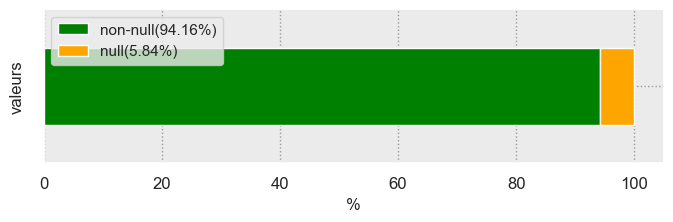

Voici les colonnes avec NaNs:


0
Column    ADJ_FACTOR
#NaN             992
%NaN            99.3
#Not_NaN           7
%Not_NaN         0.7

TICKER          FIGI      TYPE FREQUENCY   OPEN     HIGH    LOW  \
DATE                                                                         
2013-01-04    GEF  BBG000BLFQH8       EOD     daily  46.31  47.6198  46.23   
2013-01-03    GEF  BBG000BLFQH8       EOD     daily  46.43  46.5200  46.14   
2013-01-02    GEF  BBG000BLFQH8       EOD     daily  45.38  46.5400  45.16   
2018-06-05     GF  BBG000C3C6S2  Intraday     daily  18.86  18.9100  18.87   
2018-06-04     GF  BBG000C3C6S2       EOD     daily  18.86  18.8900  18.79   

            CLOSE    VOLUME   ADJ_OPEN   ADJ_HIGH    ADJ_LOW  ADJ_CLOSE  \
DATE                                                                      
2013-01-04  47.37  248000.0  38.517220  39.606614  38.450681  39.398849   
2013-01-03  46.48  131300.0  38.617027  38.691882  38.375826  38.658613   
2013-01-02  46.41  184900.0  37.743715  38.708516  37.560735  38.600392   
2018-06-05  18.87   10000.0  18.860000  18.910000  18.870000  18.870000   
2018-06-04  18.81   39095.0  18.860000  18.890000  18.790000  18.810000   

            ADJ_VOLUME  ADJ_FACTOR  EX_DIVIDEND  SPLIT_RATIO  
DATE                                                          
2013-01-04    248000.0         NaN          0.0          1.0  
2013-01-03    131300.0         NaN          0.0          1.0  
2013-01-02    184900.0         NaN          0.0          1.0  
2018-06-05     10000.0         NaN          0.0          1.0  
2018-06-04     39095.0         NaN          0.0          1.0

In [4]:
DATAPATH = 'data/stock_prices_sample.csv'
data = pd.read_csv(DATAPATH, index_col='DATE', parse_dates=['DATE'])

verifier_taille(data)
data.head()

In [5]:
print('GEF:',len(data[data.TICKER=='GEF']),'GF:',len(data[data.TICKER=='GF']))

GEF: 3 GF: 996


Le data set contient :
	- 995 lignes et 4 colonnes.
	- 0 valeurs manquantes, ce qui représente 0.0 % du data set.


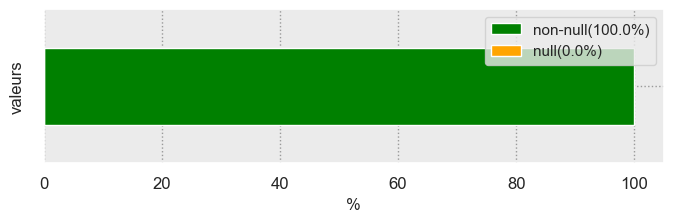

OPEN    HIGH      LOW    CLOSE
DATE                                       
2018-06-04  18.86  18.890  18.7900  18.8100
2018-06-01  18.58  18.760  18.5800  18.7400
2018-05-31  18.52  18.520  18.3012  18.4900
2018-05-30  18.47  18.678  18.4700  18.6500
2018-05-29  18.51  18.510  18.1500  18.2562

In [6]:
data = data[(data.TICKER!='GEF') & (data.TYPE!='Intraday')]
data =  data[['OPEN', 'HIGH', 'LOW', 'CLOSE']]

verifier_taille(data)
data.head()

# EDA

In [7]:
title = 'Closing price of New Germany Fund Inc (GF)'
ylabel = 'Closing price ($)'
xlabel = 'Trading day'
series = data.CLOSE
series.sort_index(inplace=True)

## Basic Plots

### Line Plot

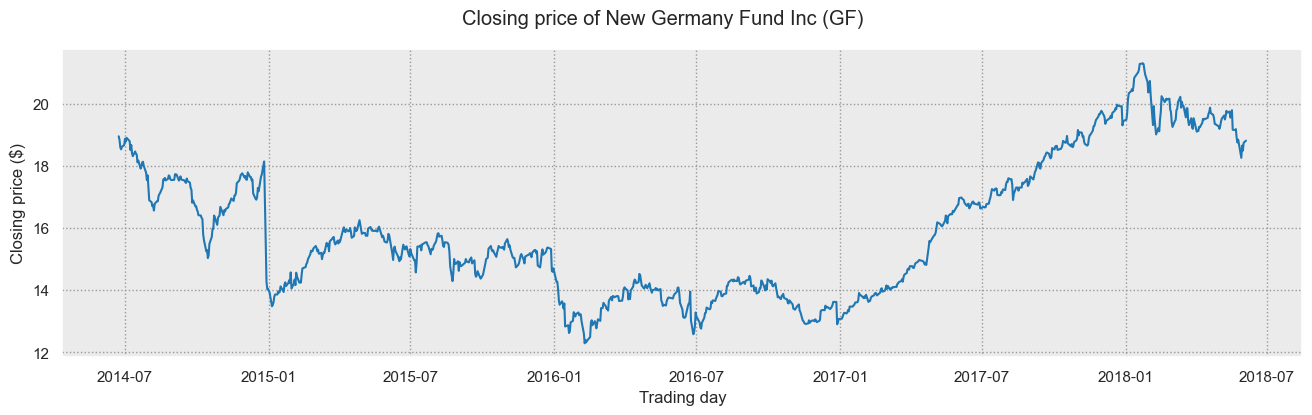

In [8]:
lineplot(series, title, xlabel, ylabel, plot_fig_args=plot_fig_args)

### Aggregation: daily, weekly, monthly, yearly

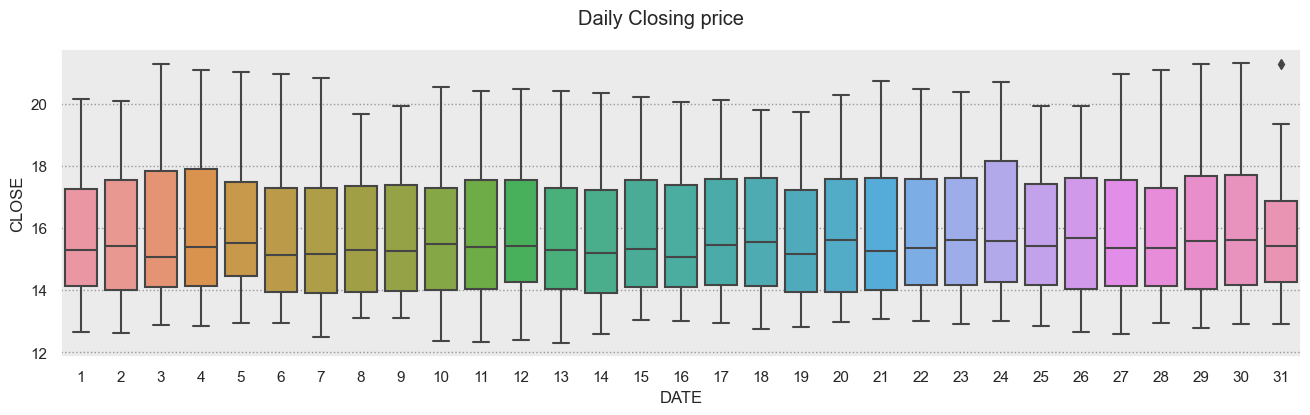

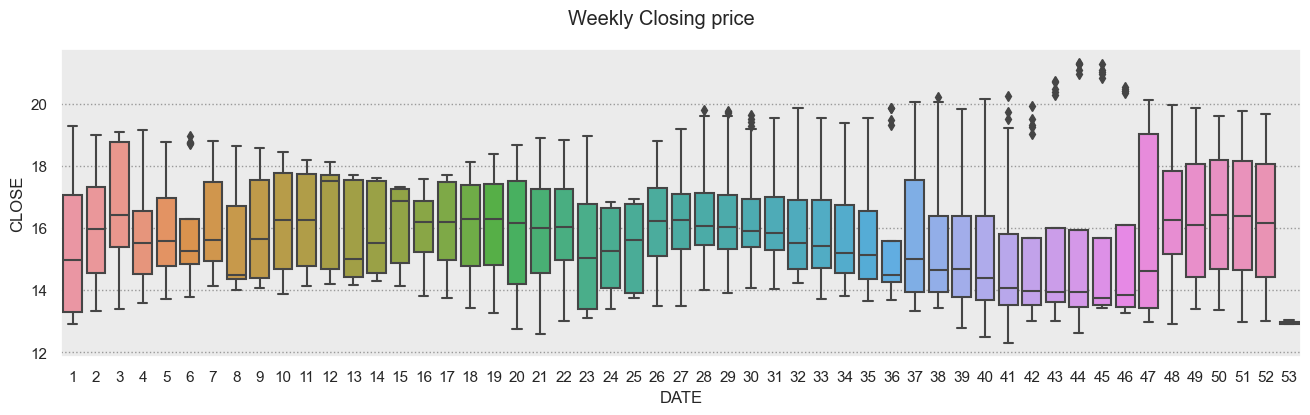

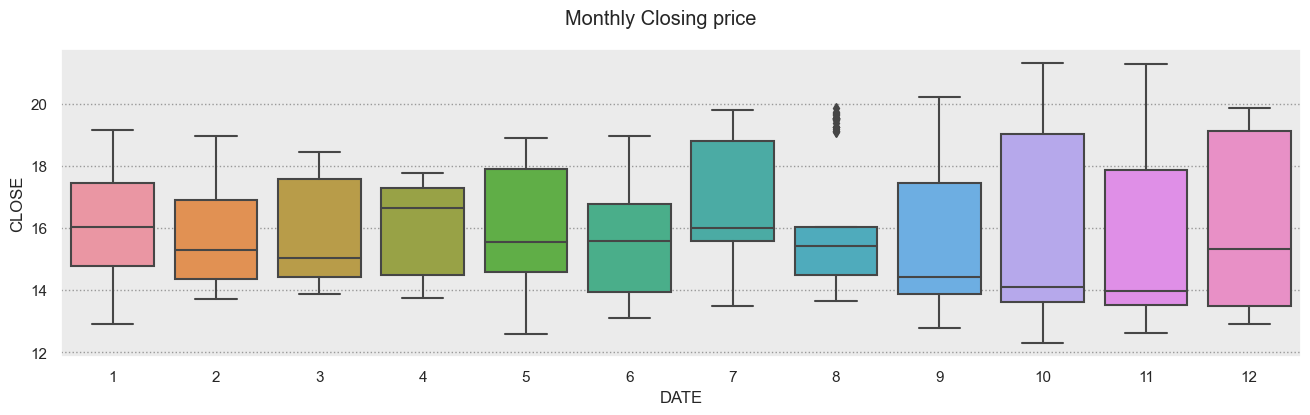

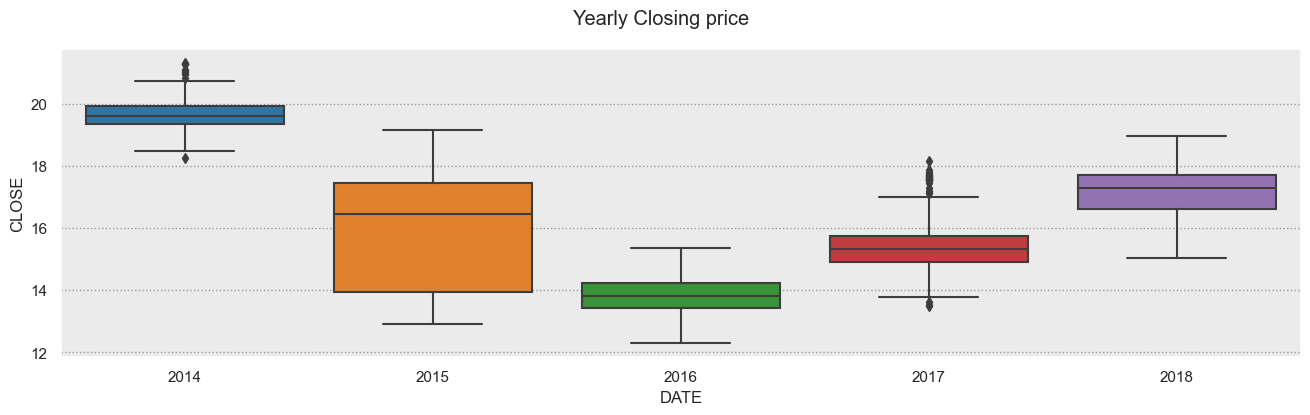

In [9]:
boxplot(series, data.index.day, 'Daily Closing price', plot_fig_args=plot_fig_args)
boxplot(series, data.index.week, 'Weekly Closing price', plot_fig_args=plot_fig_args)
boxplot(series, data.index.month, 'Monthly Closing price', plot_fig_args=plot_fig_args)
boxplot(series, data.index.year, 'Yearly Closing price', plot_fig_args=plot_fig_args)

## Sationarity Analysis

### Autocorrelation & ADF

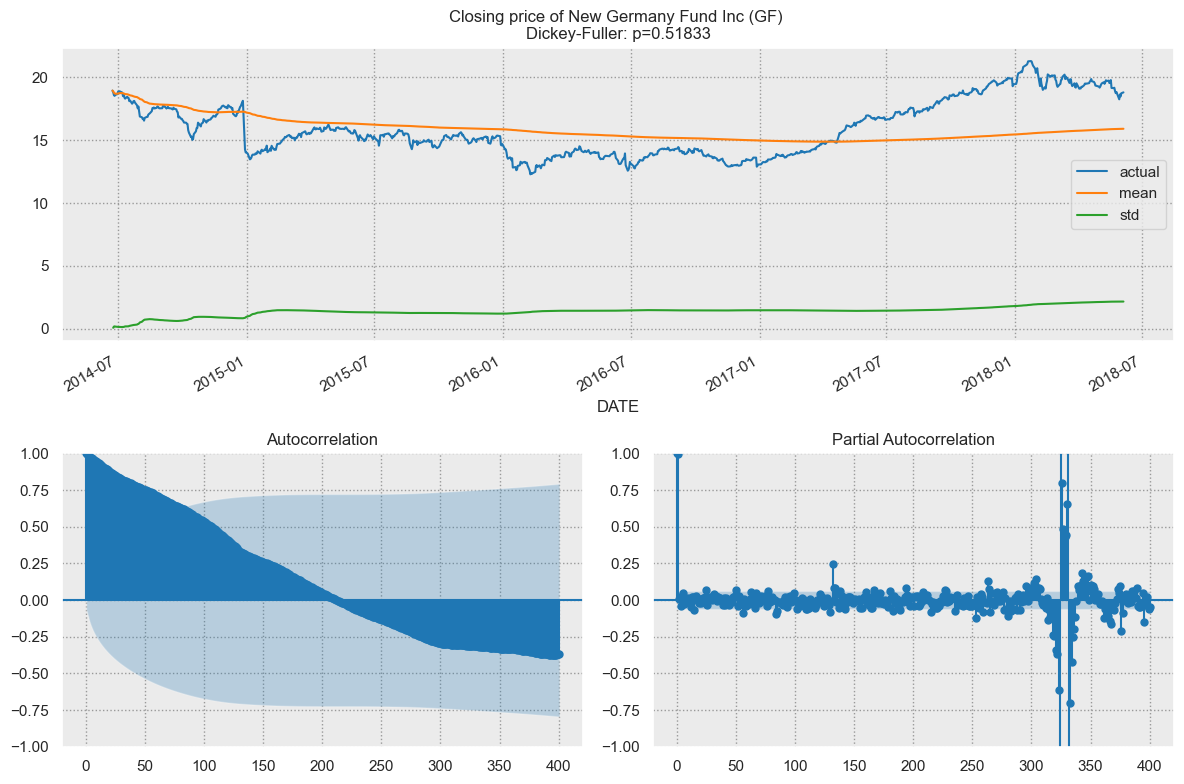

In [10]:
plot_tsa(series, title, 400, plot_tsa_fig_args)

### Heteroskedasticity Test

In [11]:
Heteroskedasticity.run_all_tests(series)

{'White': 2.8221368187127205e-20,
 'Breusch-Pagan': 0.0003738227449717615,
 'Goldfeld-Quandt': 0.15405444185492304}

In [12]:
Heteroskedasticity.run_all_tests(np.sqrt(series))

{'White': 2.008983250151806e-16,
 'Breusch-Pagan': 0.0012082284601017134,
 'Goldfeld-Quandt': 0.4964064972655101}

In [13]:
# transforming the series
# lambda_ is the transformation parameter
series_transformed, lambda_ = boxcox(series)
series_transformed = pd.Series(series_transformed, index=series.index)
print(lambda_)

-1.5569880864716075


In [14]:
Heteroskedasticity.run_all_tests(series_transformed)

{'White': 0.000610908959357441,
 'Breusch-Pagan': 0.029980908836701913,
 'Goldfeld-Quandt': 0.19658558987833297}

### STL decomposition (Trend, Seasonal, Remainder)

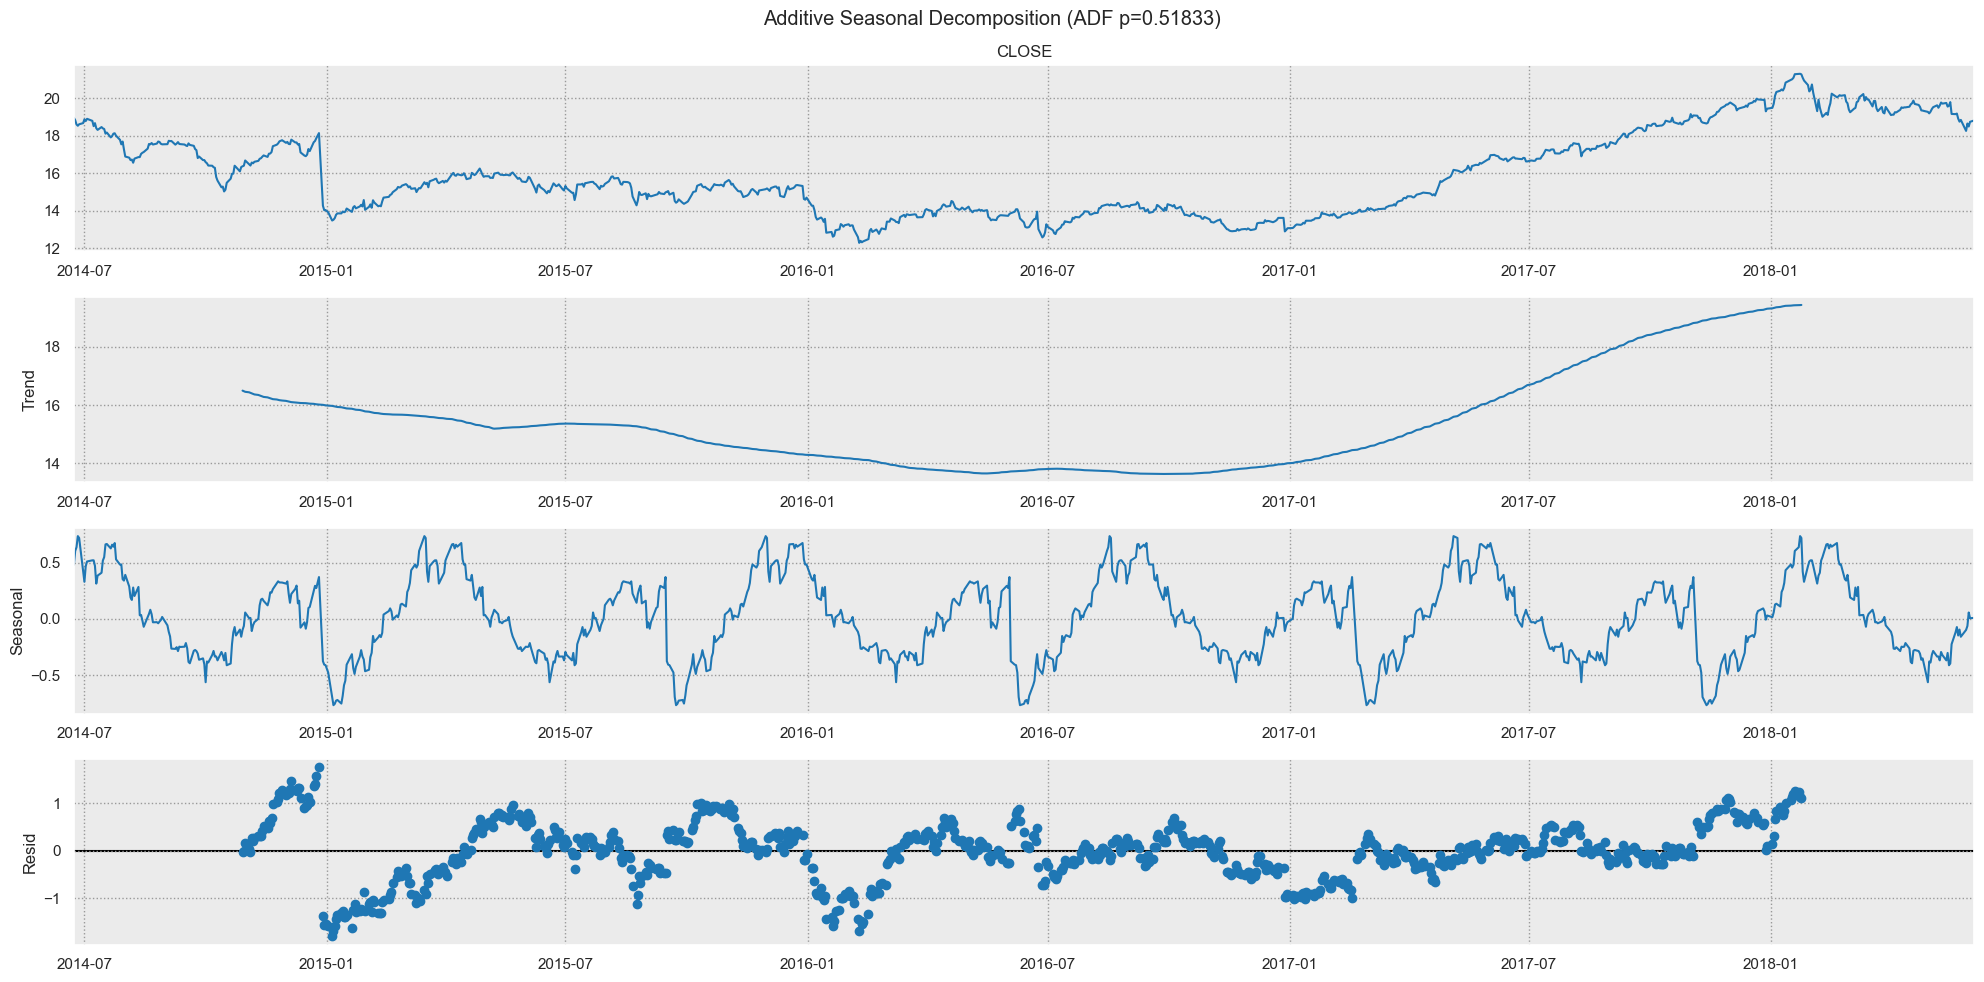

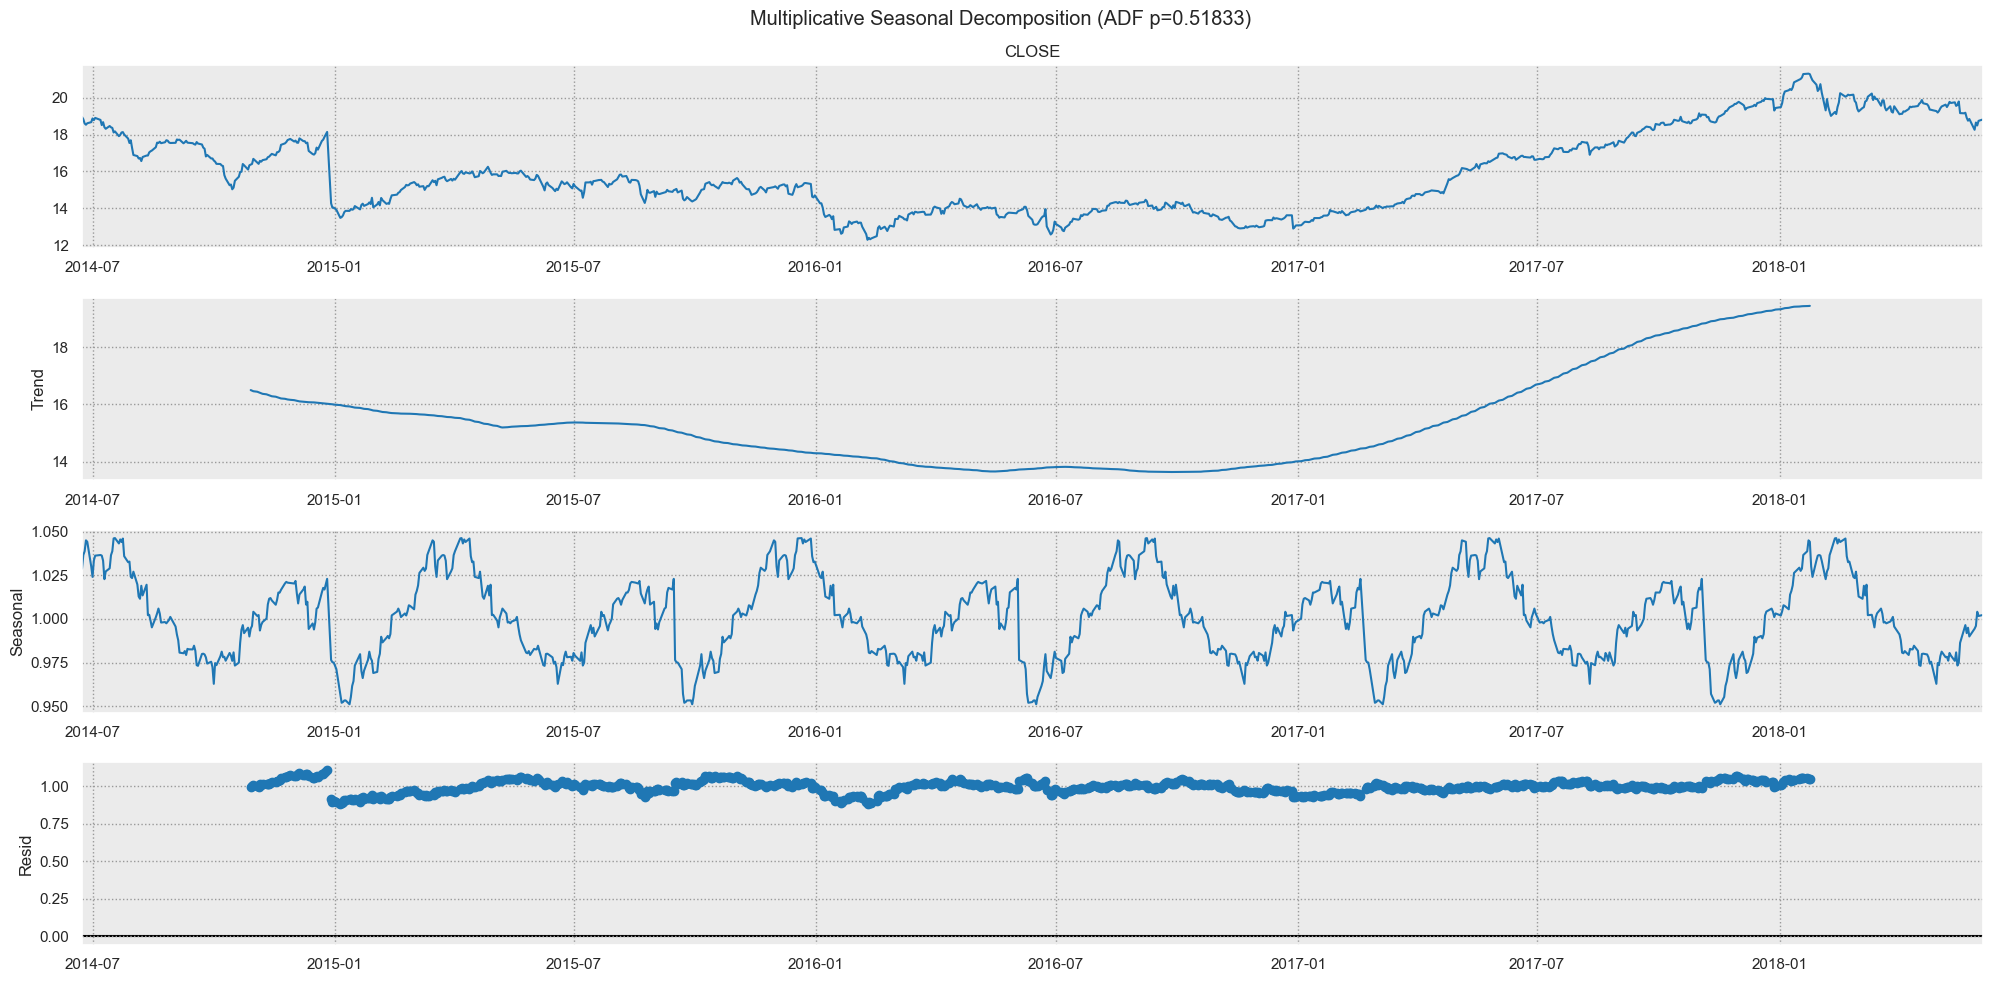

In [15]:
plot_seasonal_decompose(series, 'add', 30*6, plot_seasonal_decompose_fig_args)
plot_seasonal_decompose(series, 'multi', 30*6, plot_seasonal_decompose_fig_args)

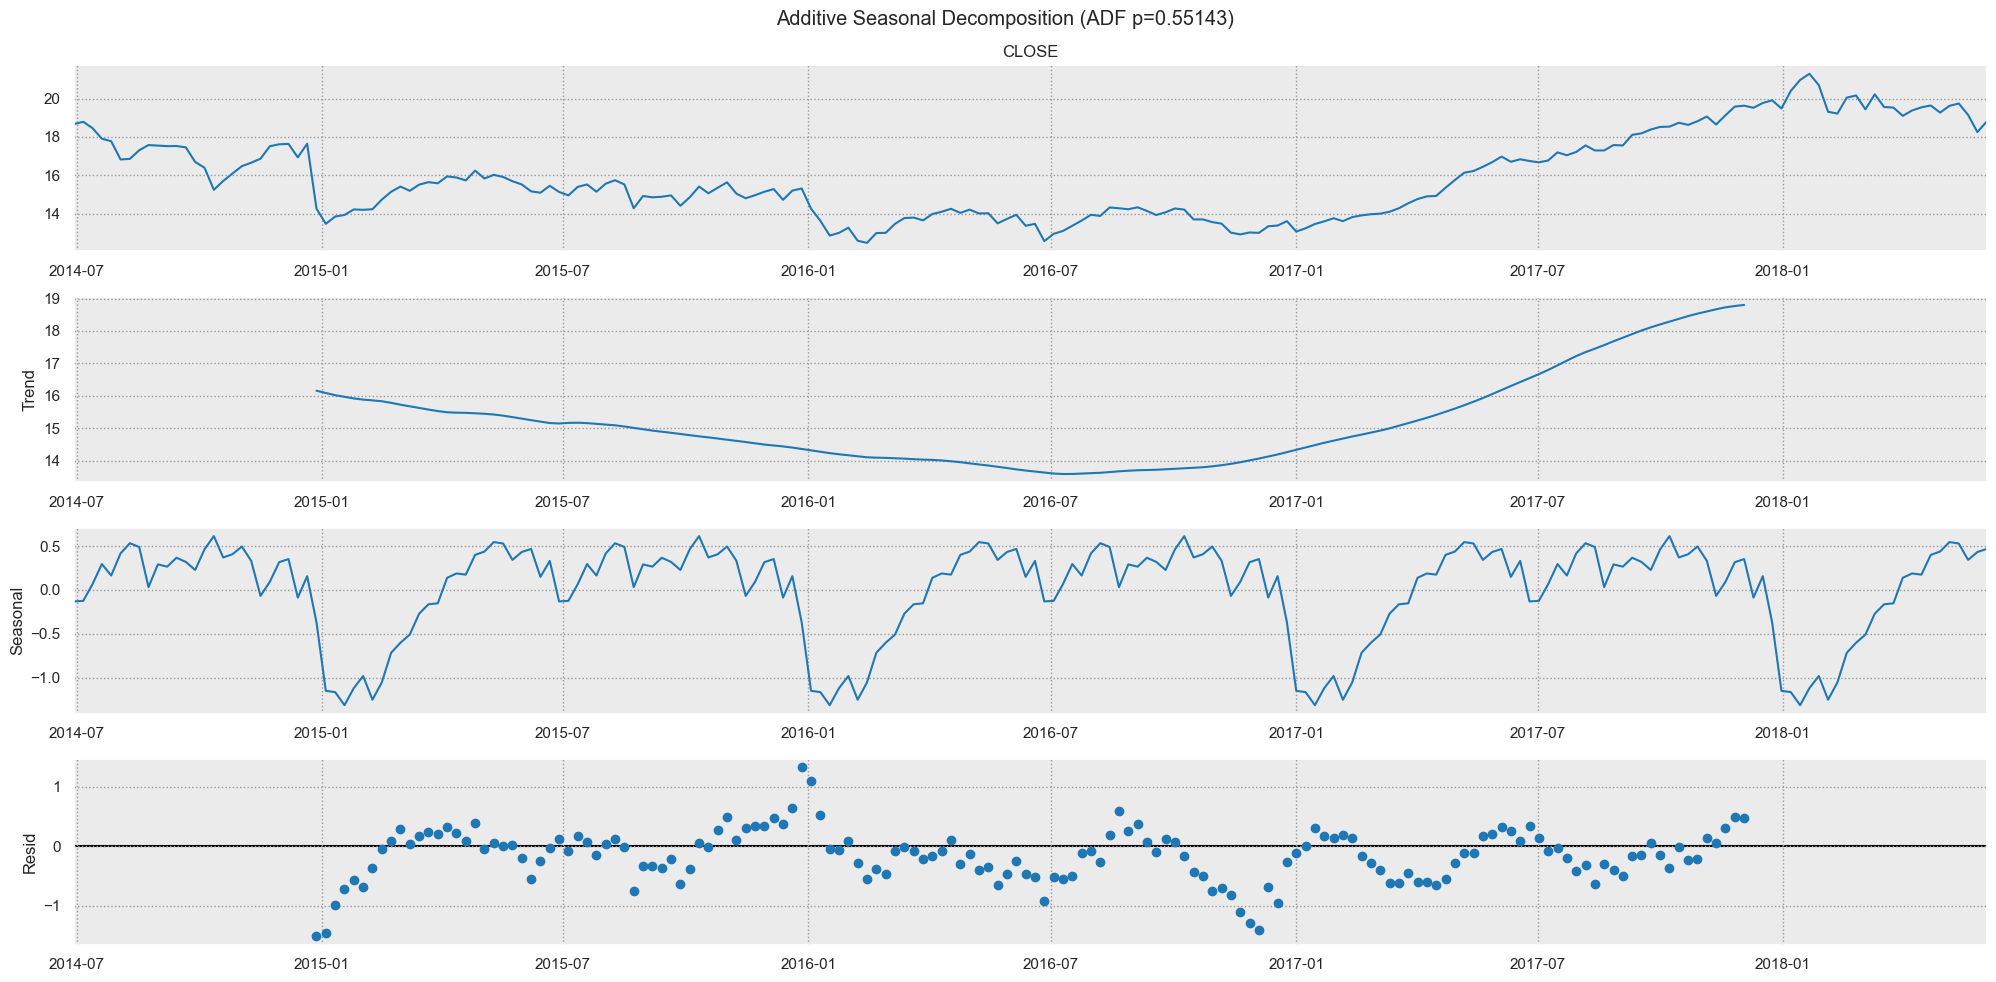

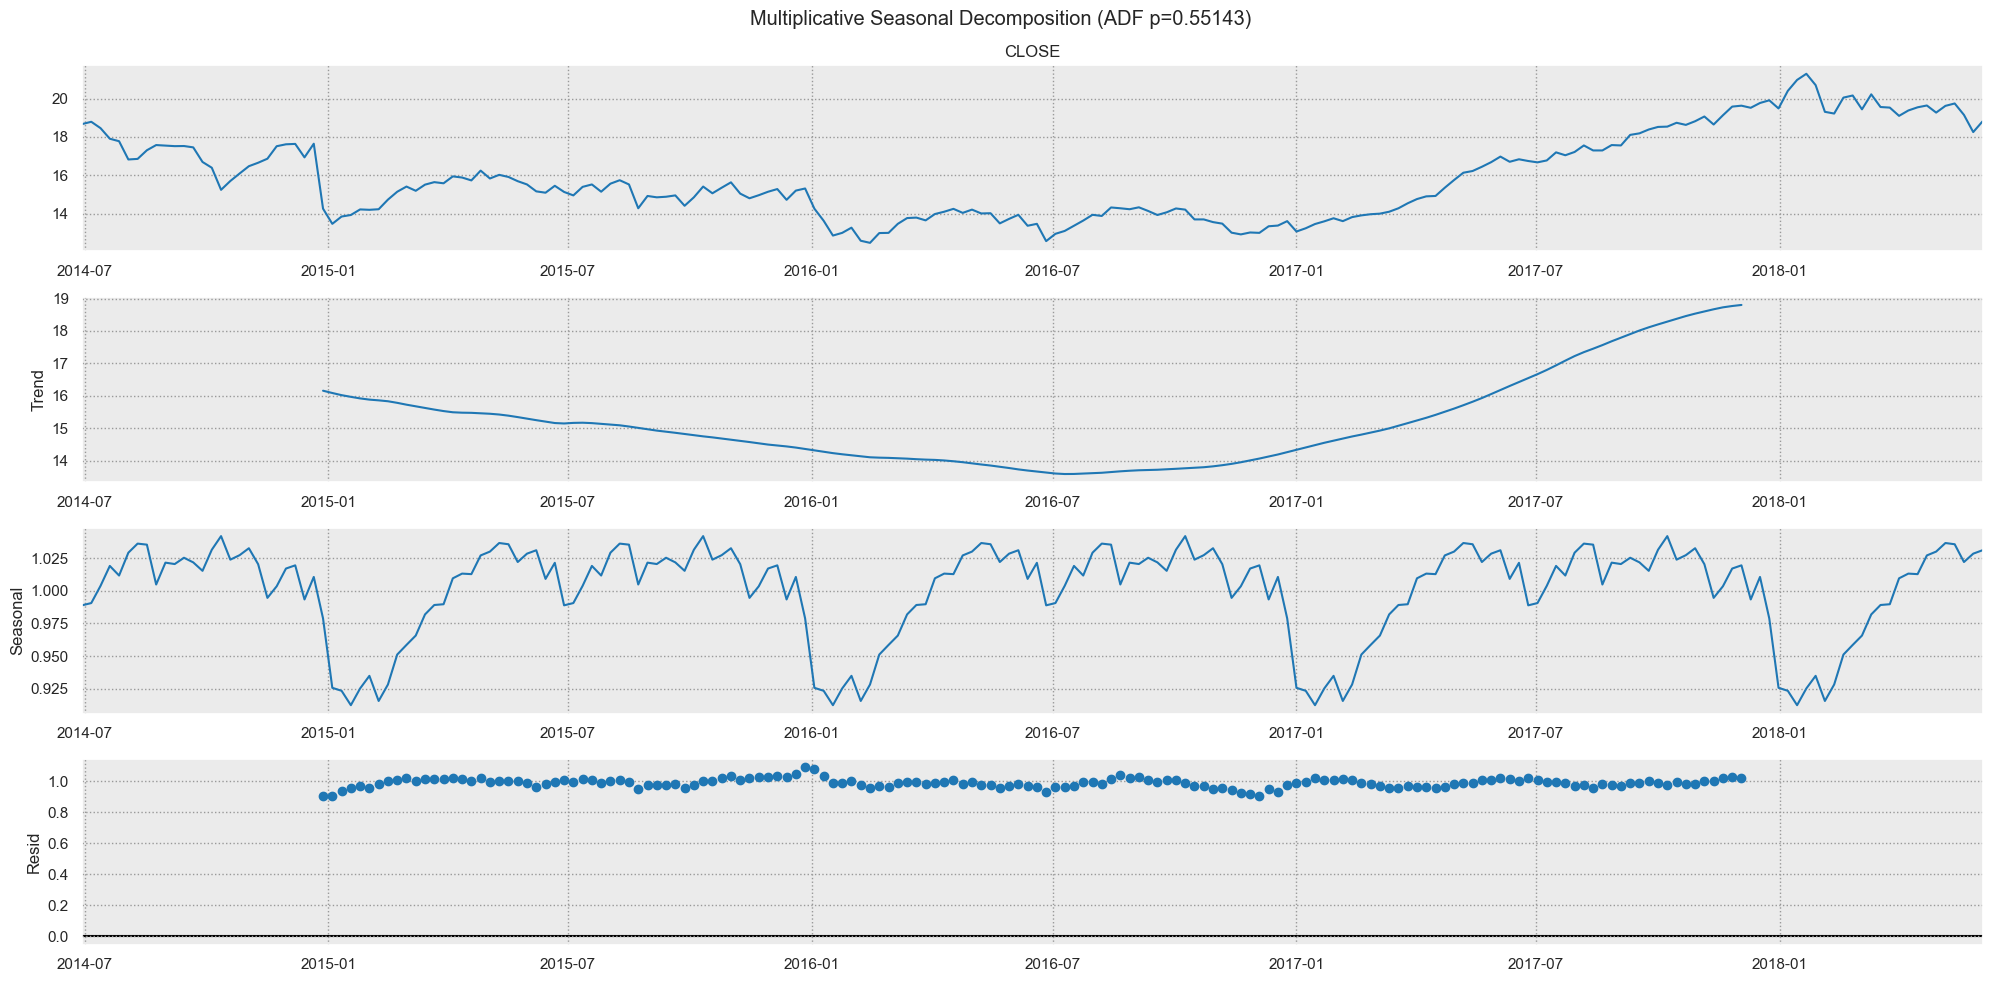

In [16]:
plot_seasonal_decompose(series.asfreq('W', 'bfill'), 'add', None, plot_seasonal_decompose_fig_args)
plot_seasonal_decompose(series.asfreq('W', 'bfill'), 'mult', None, plot_seasonal_decompose_fig_args)

## Differencing

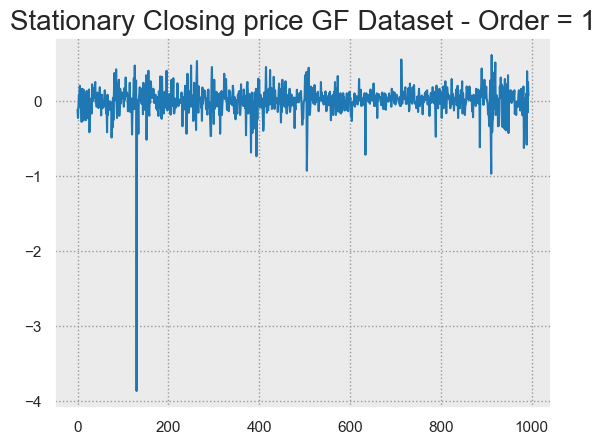

In [17]:
ap_stationary = make_stationary(series, 0.01)

plt.title(f"Stationary Closing price GF Dataset - Order = {ap_stationary['differencing_order']}", size=20)
plt.plot(ap_stationary['time_series'])

In [18]:
# Take the first difference to remove to make the process stationary
data_diff = series.diff(periods=1)[1:]
data_diff[data_diff<=0]=np.median(data_diff)

## Sationarity Analysis after Differencing

### Autocorrelation & ADF

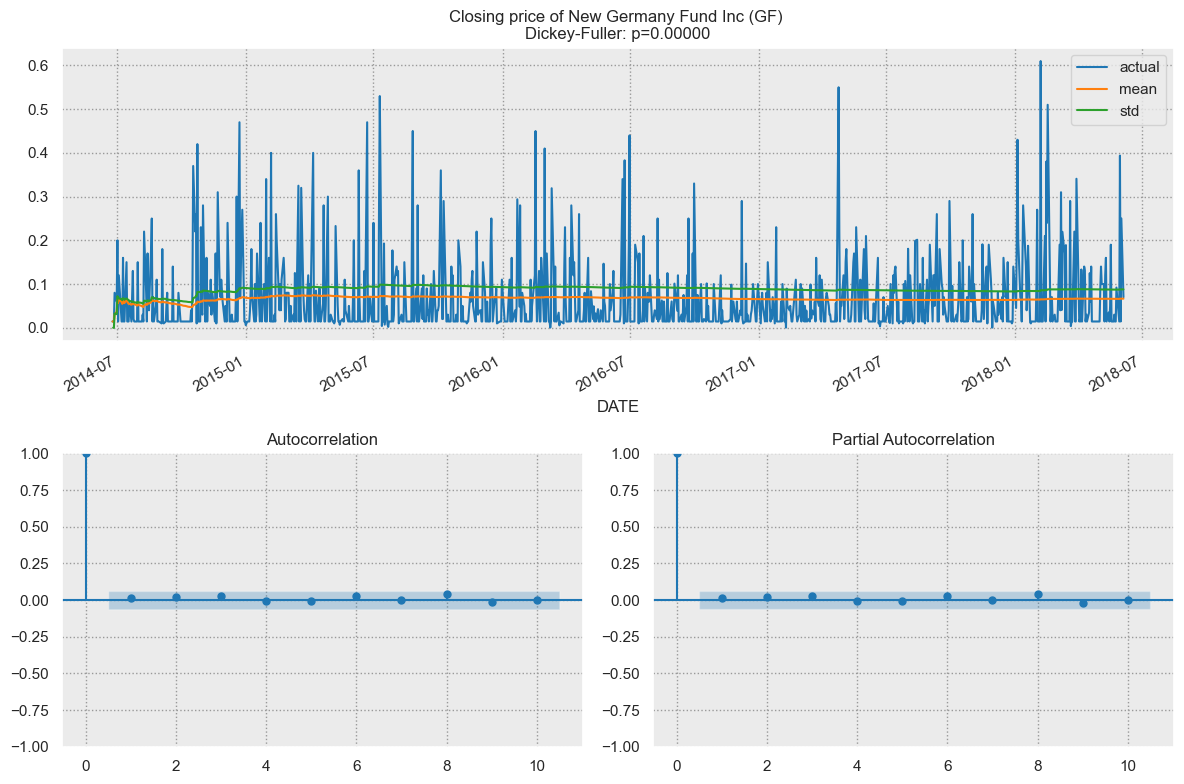

In [19]:
plot_tsa(data_diff, title, 10, plot_tsa_fig_args)

### Heteroskedasticity Test

In [20]:
Heteroskedasticity.run_all_tests(data_diff)

{'White': 0.29118935350361963,
 'Breusch-Pagan': 0.8033502667007323,
 'Goldfeld-Quandt': 0.06284330613776953}

In [21]:
# transforming the series
# lambda_ is the transformation parameter
data_diff_transformed, lambda_ = boxcox(data_diff)
data_diff_transformed = pd.Series(series_transformed, index=data_diff.index)
print(lambda_)

-0.12385062012244966


In [22]:
Heteroskedasticity.run_all_tests(data_diff_transformed)

{'White': 0.0008153606443682047,
 'Breusch-Pagan': 0.03049273796542972,
 'Goldfeld-Quandt': 0.20745929652356052}

### STL decomposition (Trend, Seasonal, Remainder)

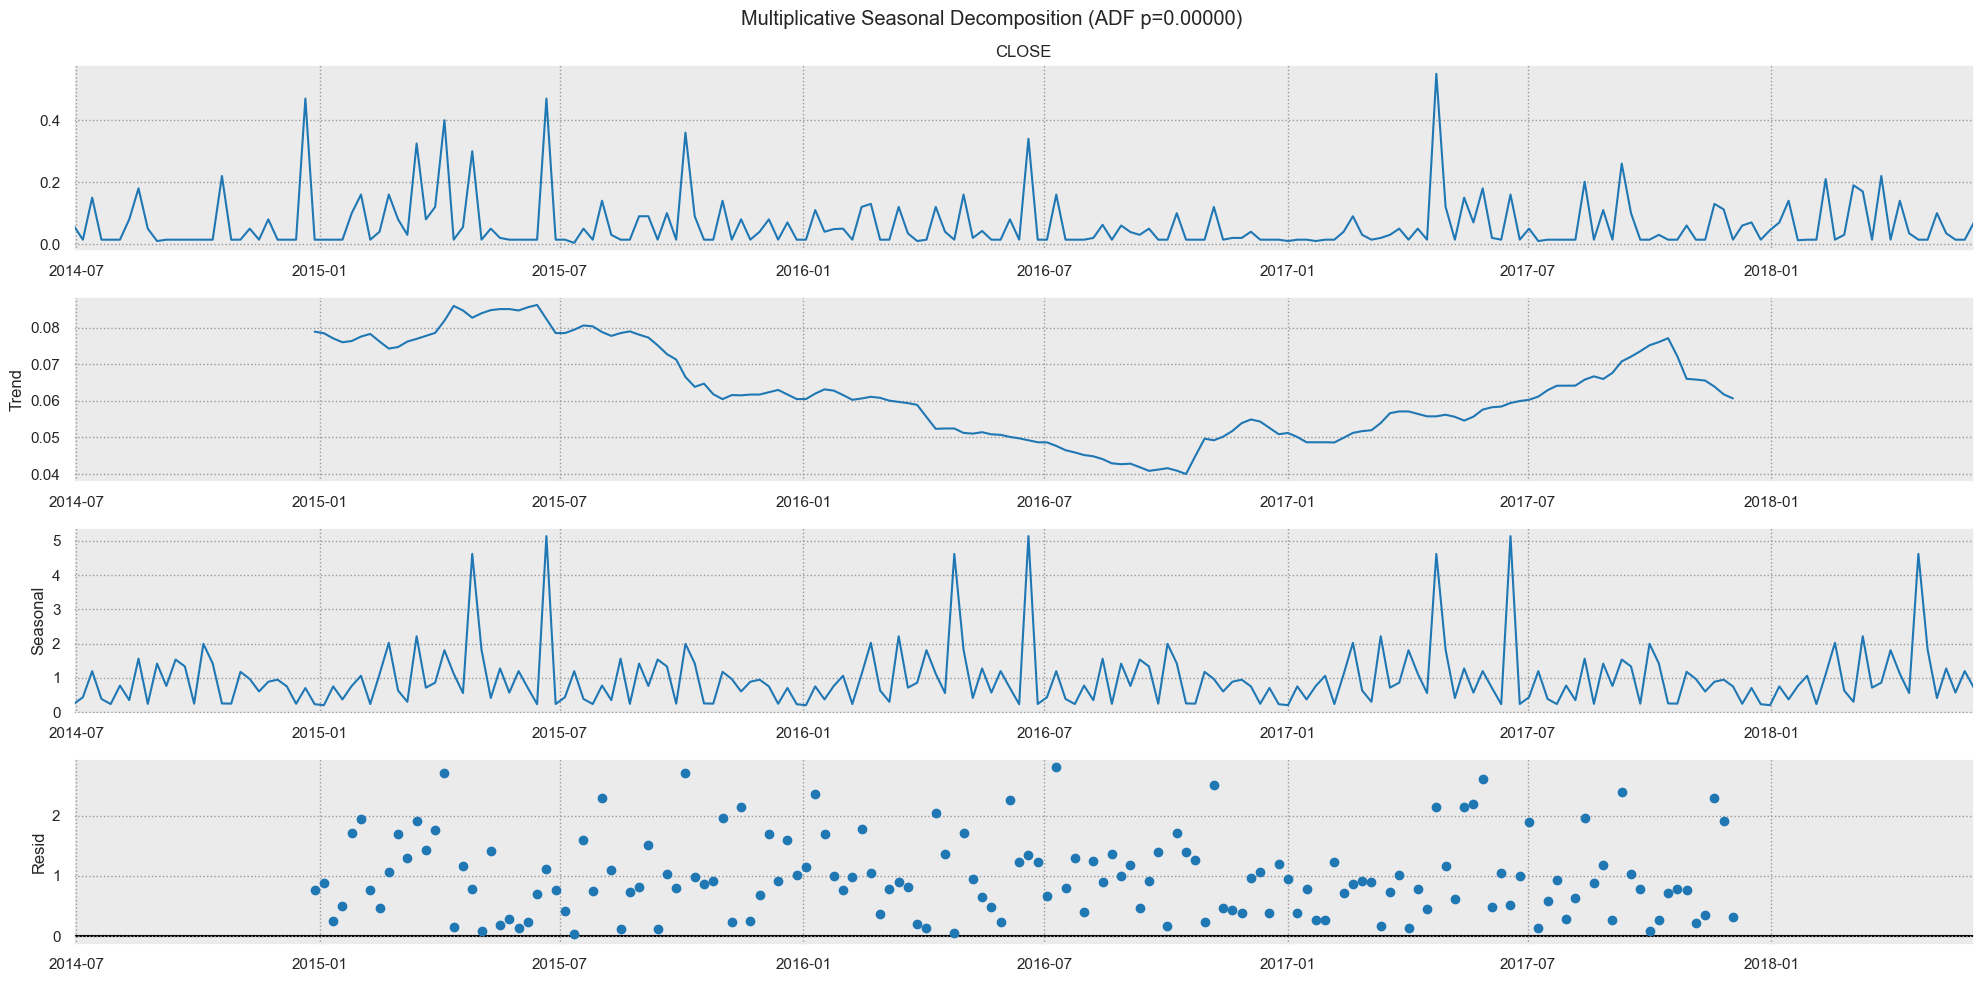

In [23]:
plot_seasonal_decompose(data_diff.asfreq('W', 'bfill'), 'mult', None, plot_seasonal_decompose_fig_args)

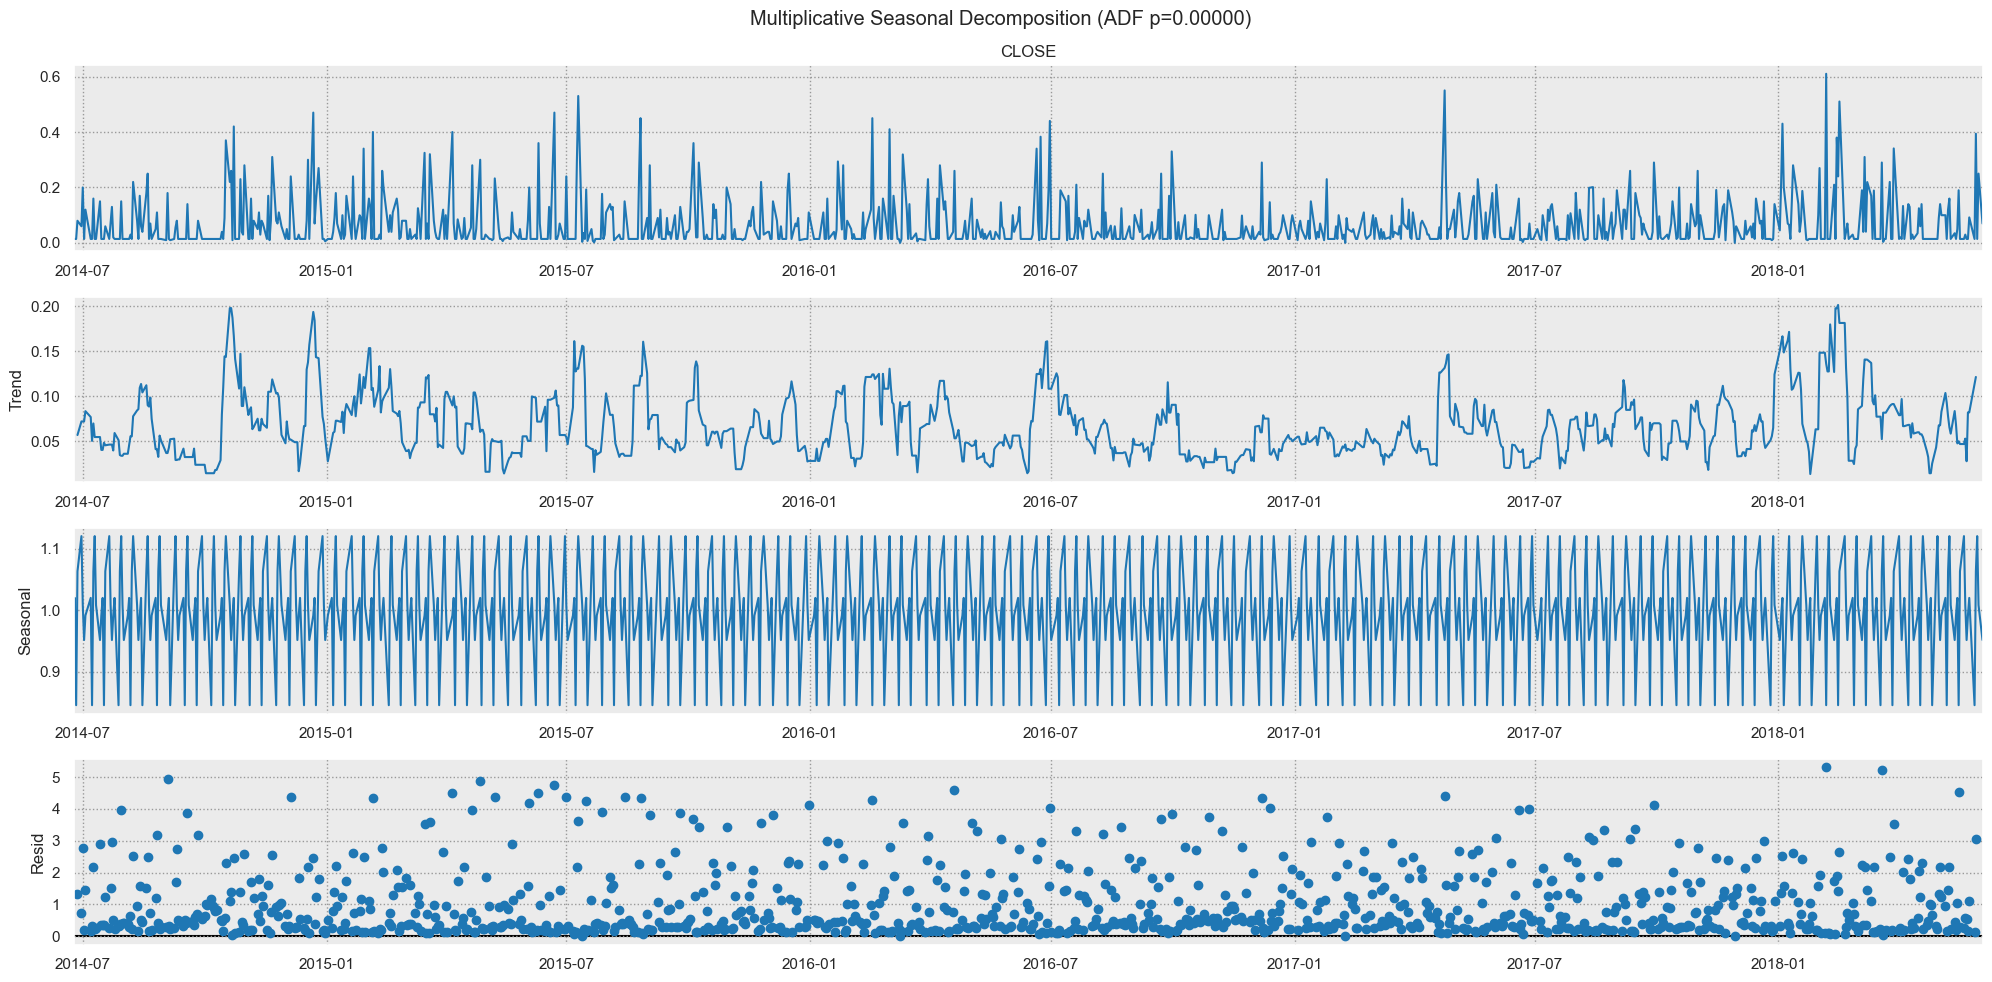

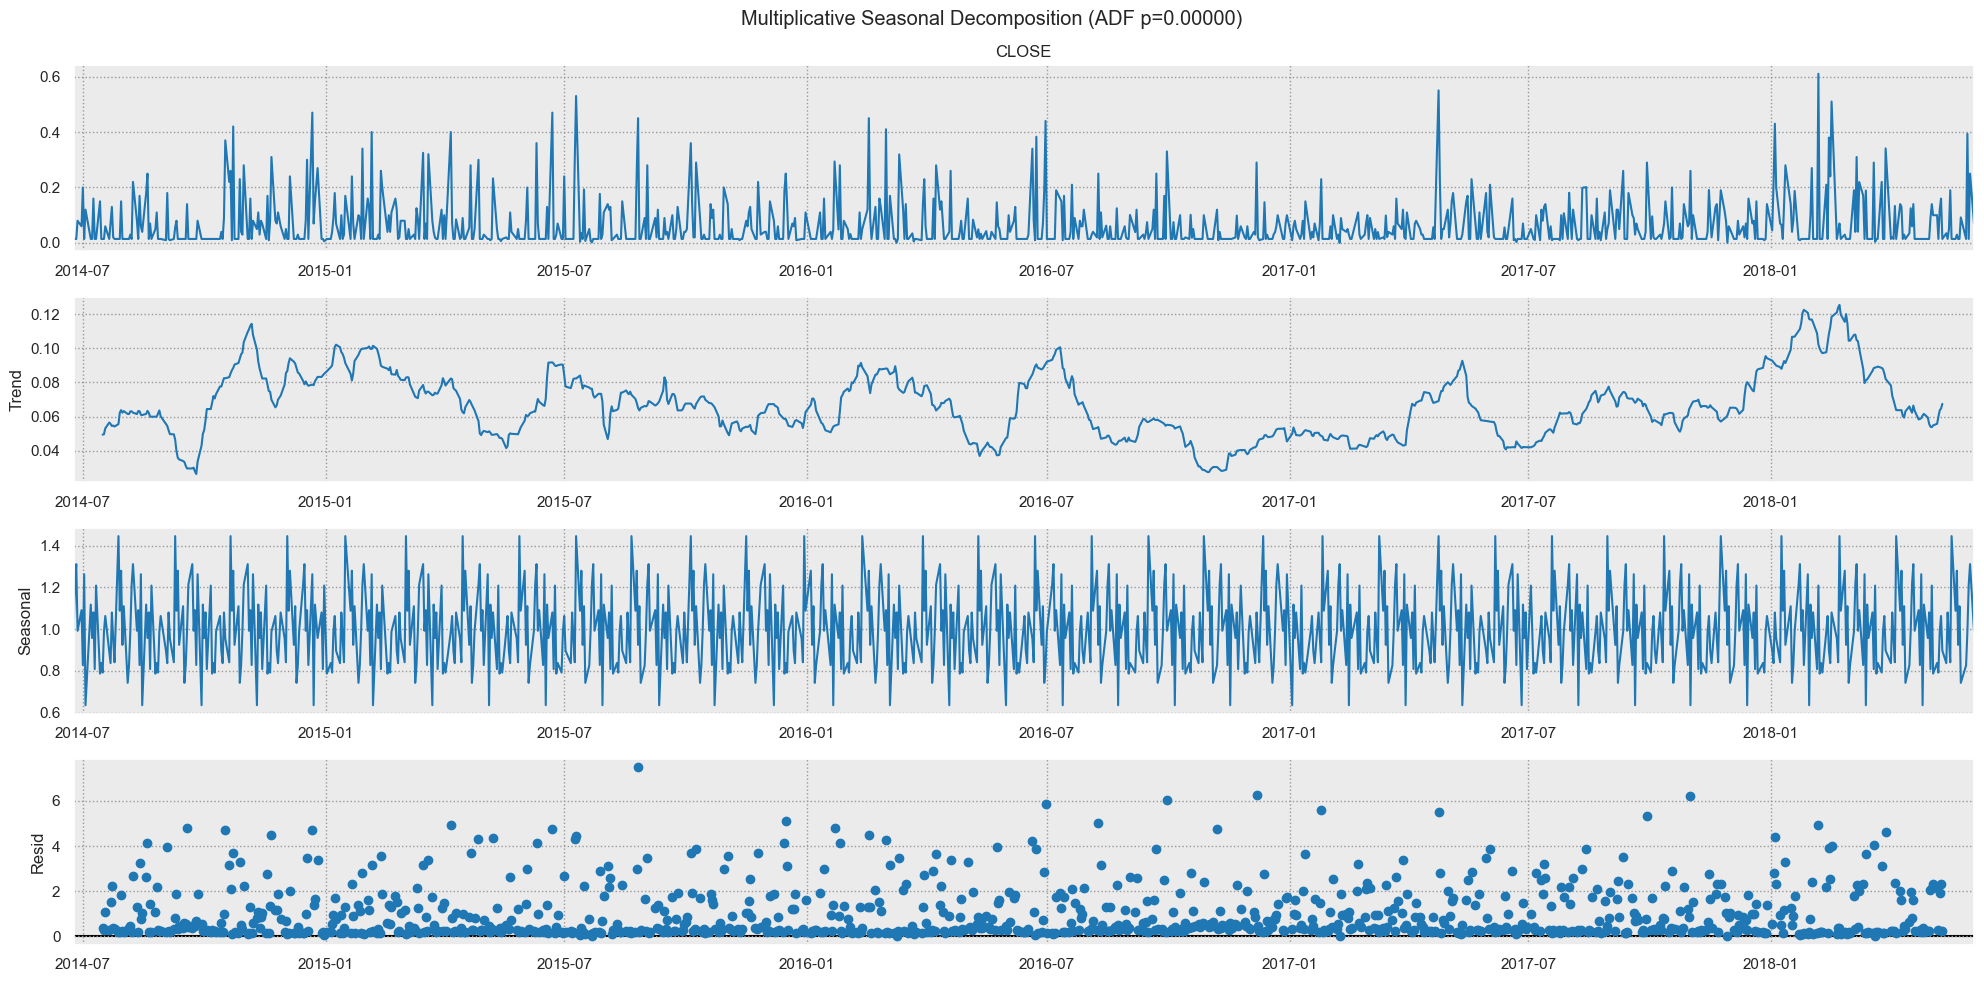

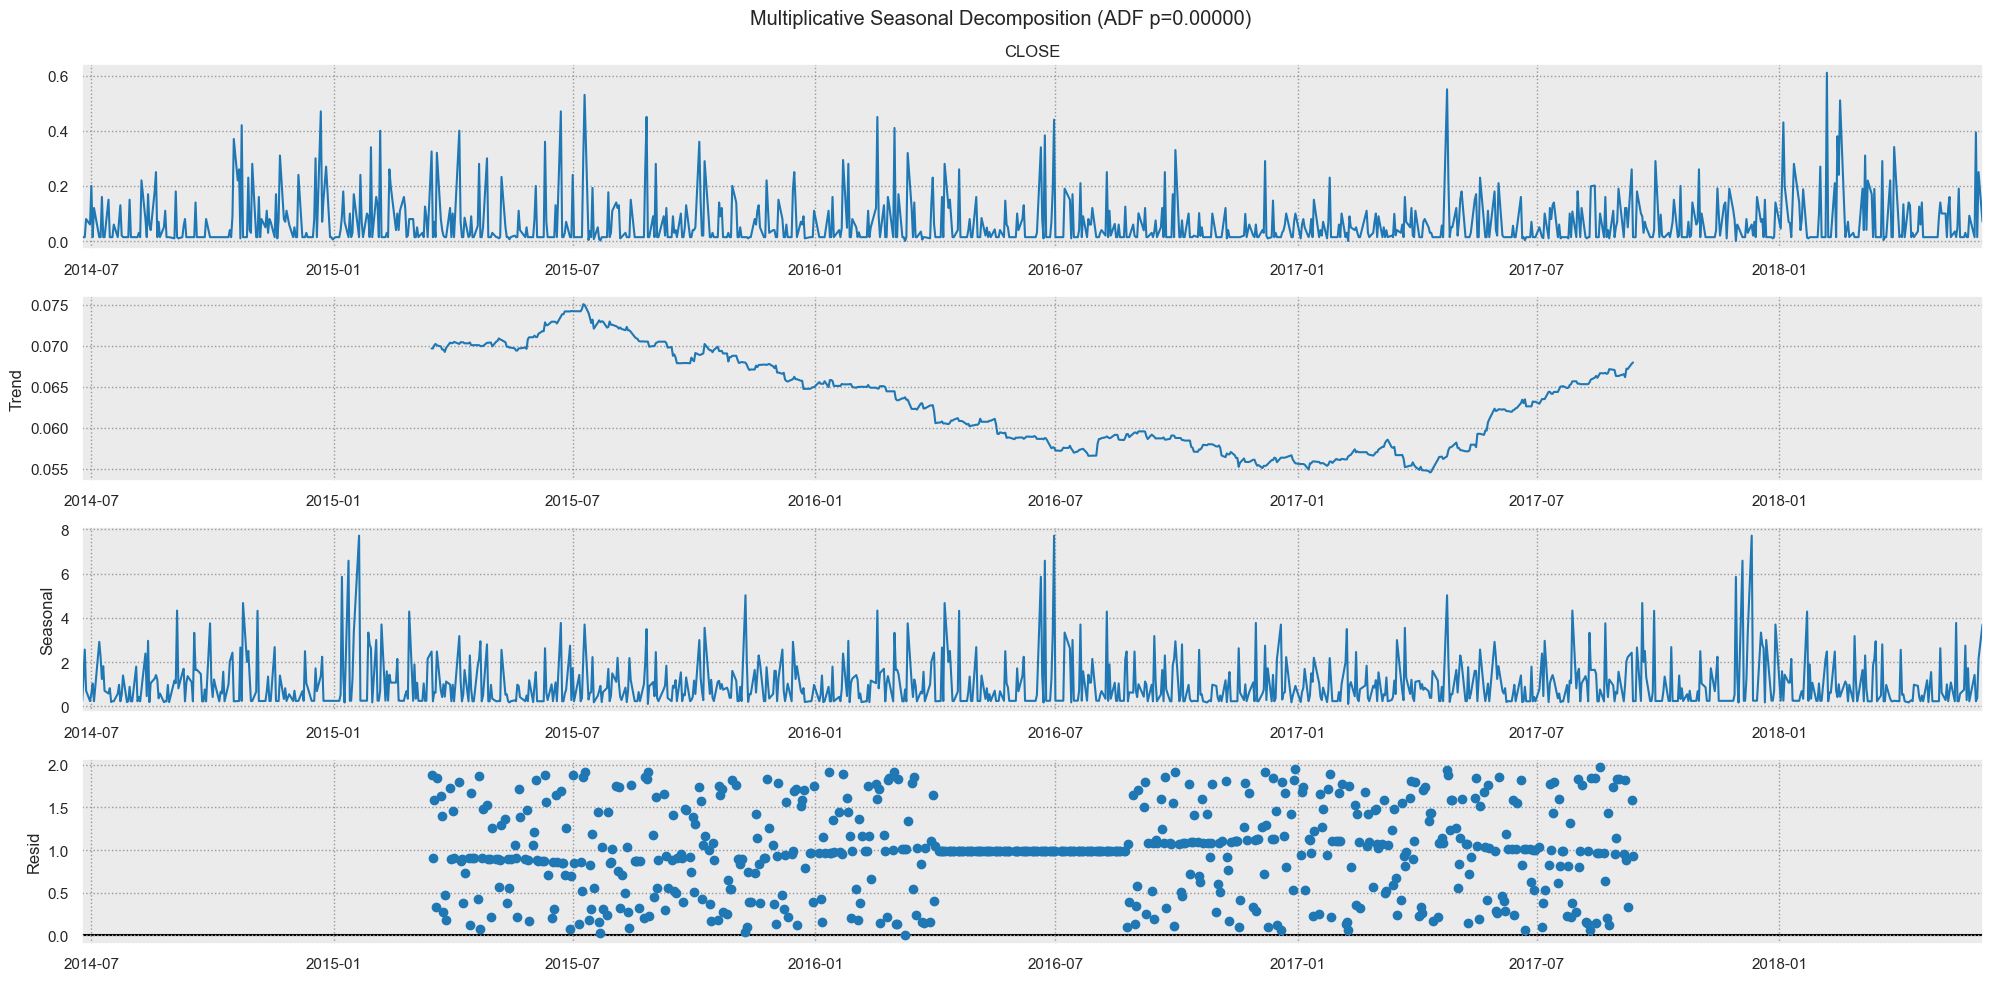

In [24]:
plot_seasonal_decompose(data_diff, 'multi', 7, plot_seasonal_decompose_fig_args)
plot_seasonal_decompose(data_diff, 'multi', 30, plot_seasonal_decompose_fig_args)
plot_seasonal_decompose(data_diff, 'multi', 365, plot_seasonal_decompose_fig_args)

# Stats Modeling

## Moving Average (MA)

### Simple Moving Average

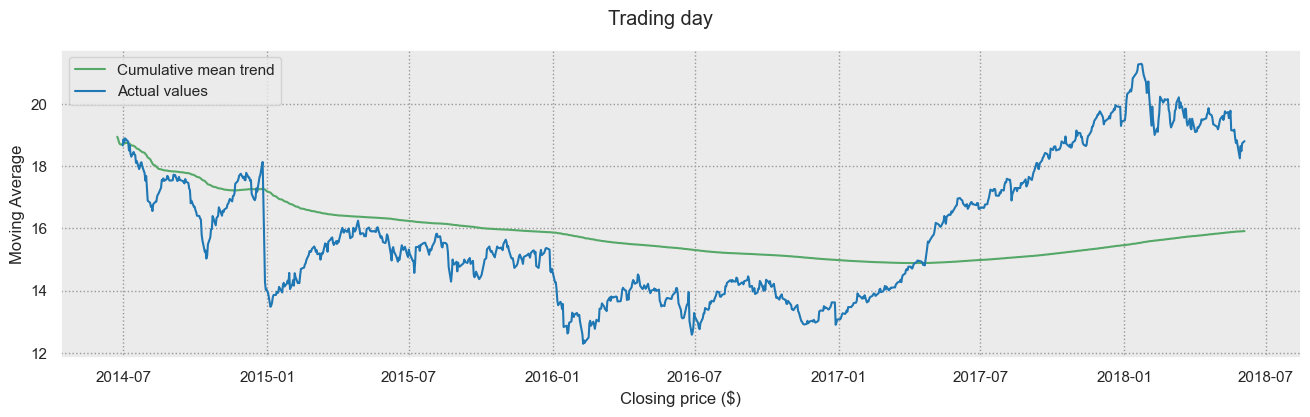

In [25]:
plot_cumulative_average(series, 5, xlabel, ylabel, plot_fig_args)

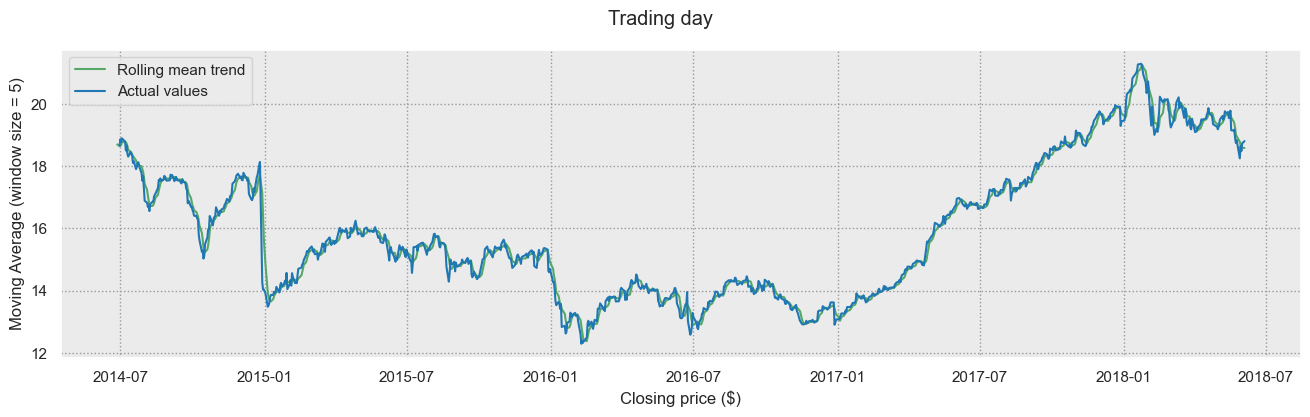

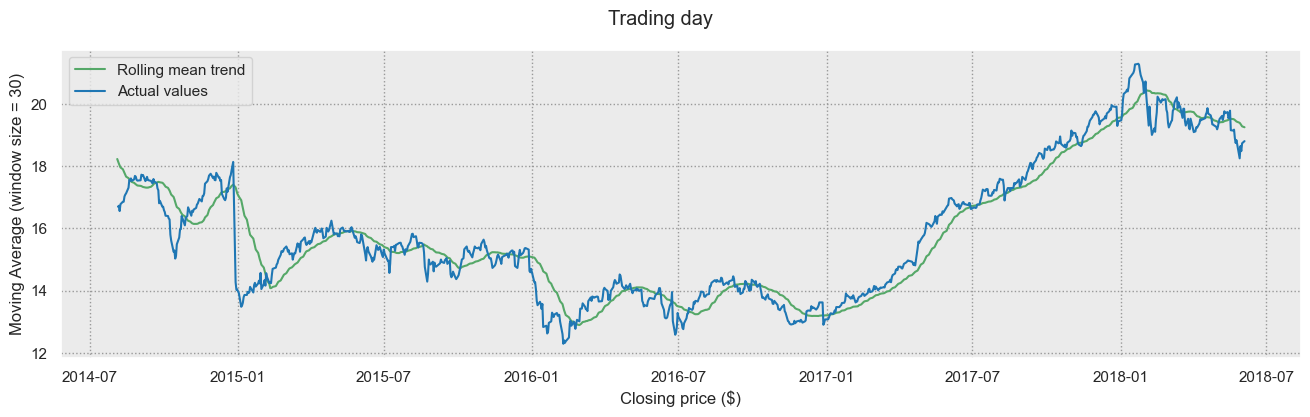

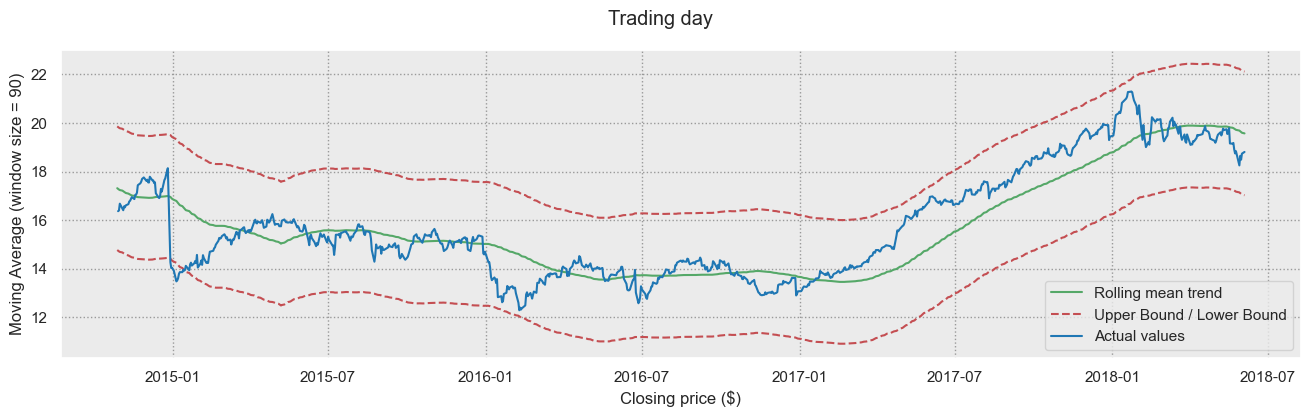

In [26]:
#Smooth by the previous 5 days (by week)
plot_moving_average(series, 5, xlabel, ylabel, plot_fig_args=plot_fig_args)

#Smooth by the previous month (30 days)
plot_moving_average(series, 30, xlabel, ylabel, plot_fig_args=plot_fig_args)

#Smooth by previous quarter (90 days)
plot_moving_average(series, 90, xlabel, ylabel, plot_intervals=True, plot_fig_args=plot_fig_args)

### Weighted Moving Average : Exponential Smoothing

#### Simple Exponential Smoothing (SES)

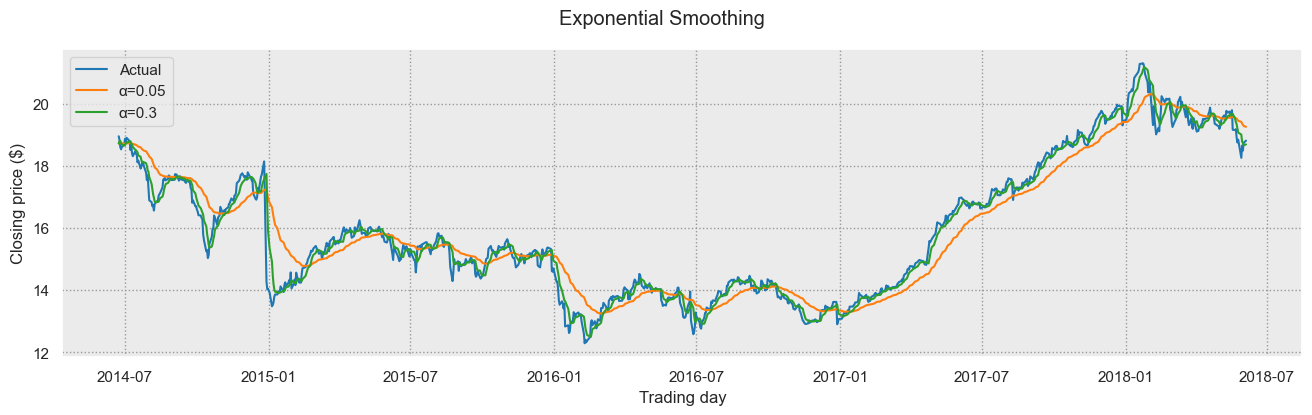

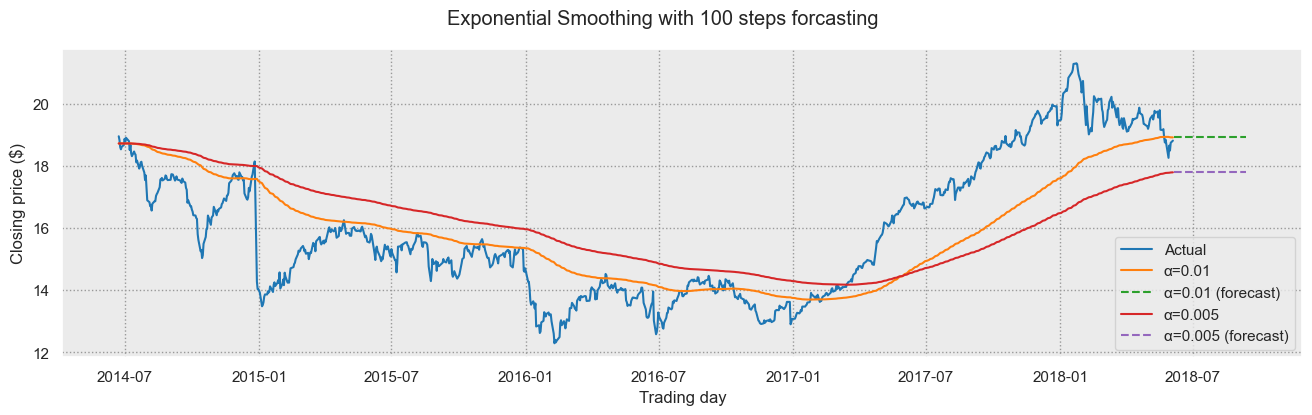

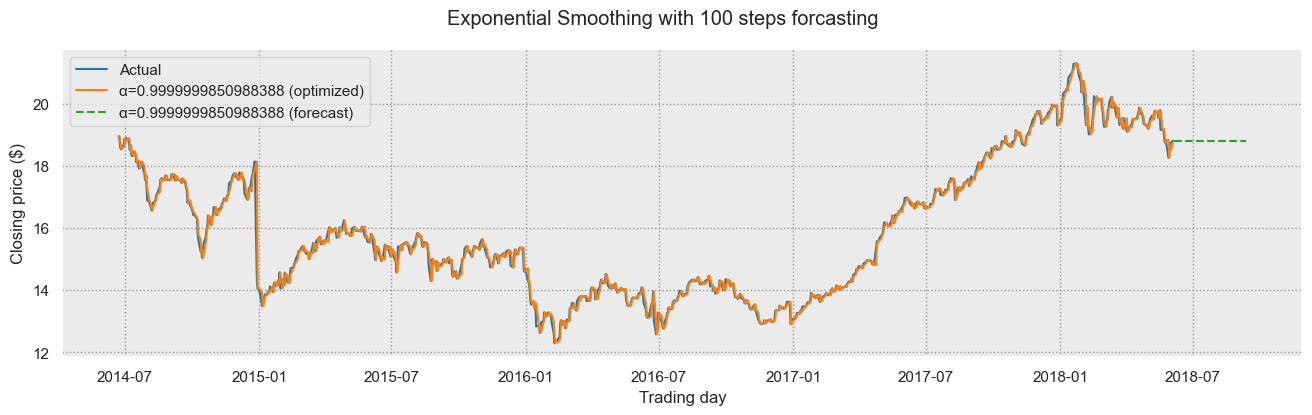

In [27]:
plot_simple_exponential_smoothing(series, xlabel, ylabel, [0.05, 0.3], 0, plot_fig_args)
plot_simple_exponential_smoothing(series, xlabel, ylabel, [0.01, 0.005], 100, plot_fig_args)
plot_simple_exponential_smoothing(series, xlabel, ylabel, [], 100, plot_fig_args=plot_fig_args)

#### Double Exponential Smoothing (Holt's method)

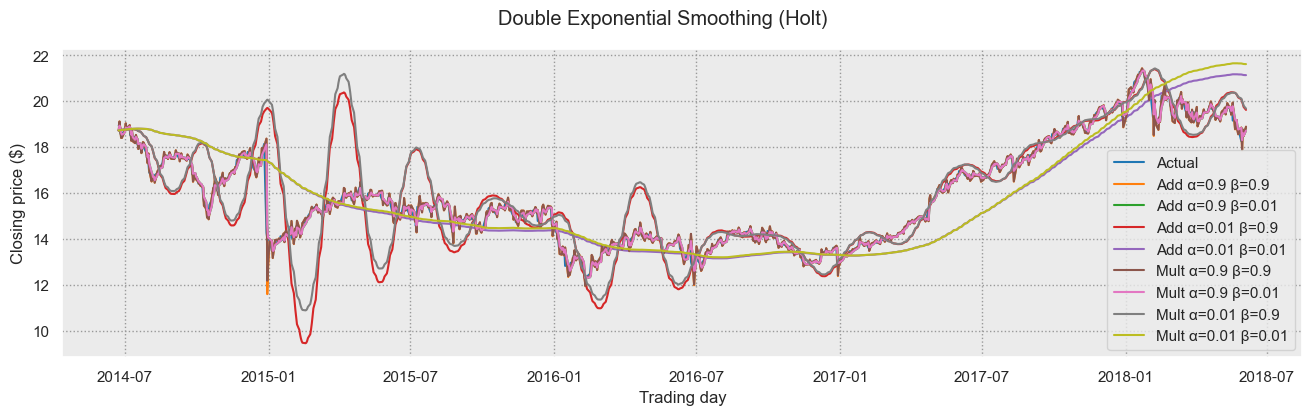

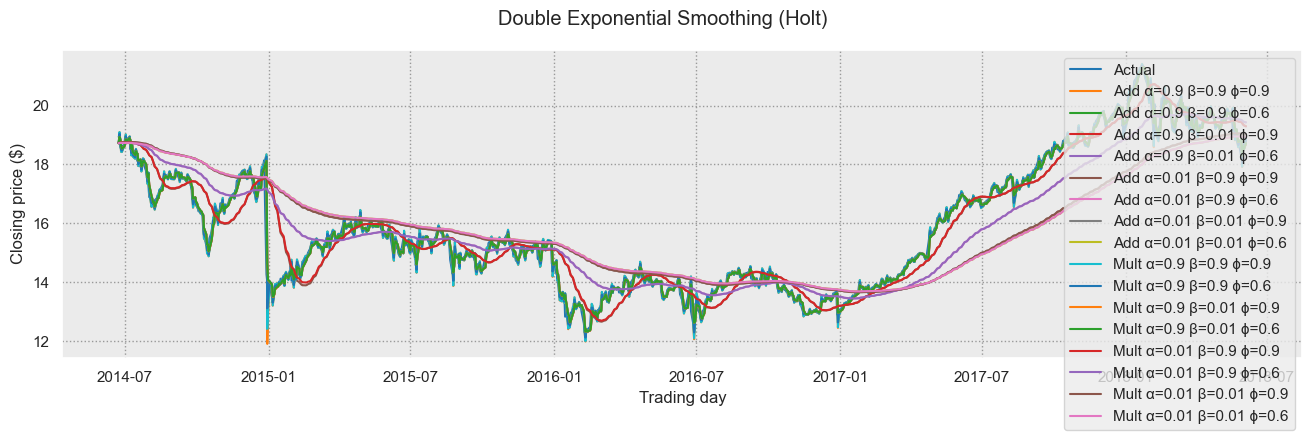

In [28]:
plot_double_exponential_smoothing(series, xlabel, ylabel, [0.9, 0.01], [0.9, 0.01], [], True, True, 0, plot_fig_args)
plot_double_exponential_smoothing(series, xlabel, ylabel, [0.9, 0.01], [0.9, 0.01], [0.9, 0.6], True, True, 0, plot_fig_args)

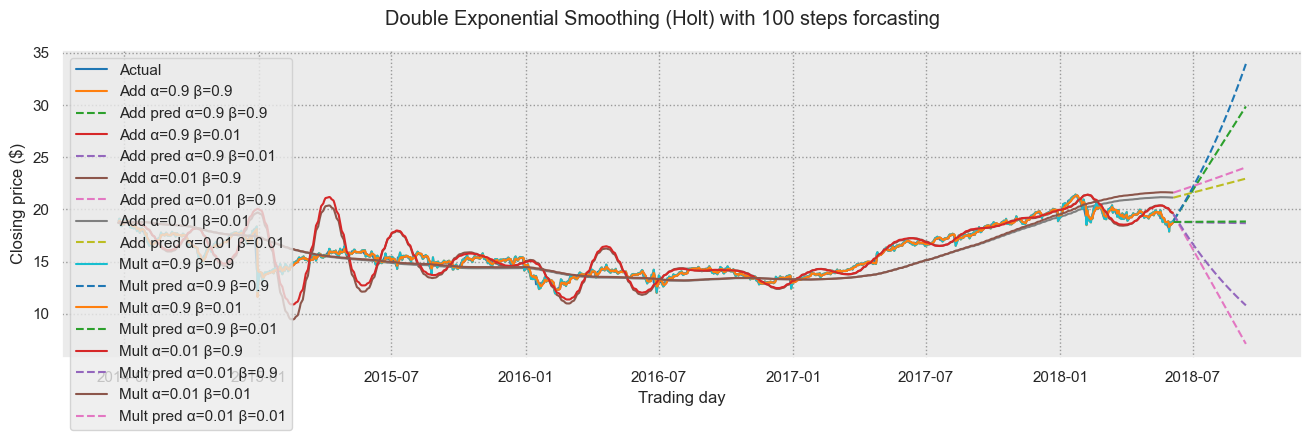

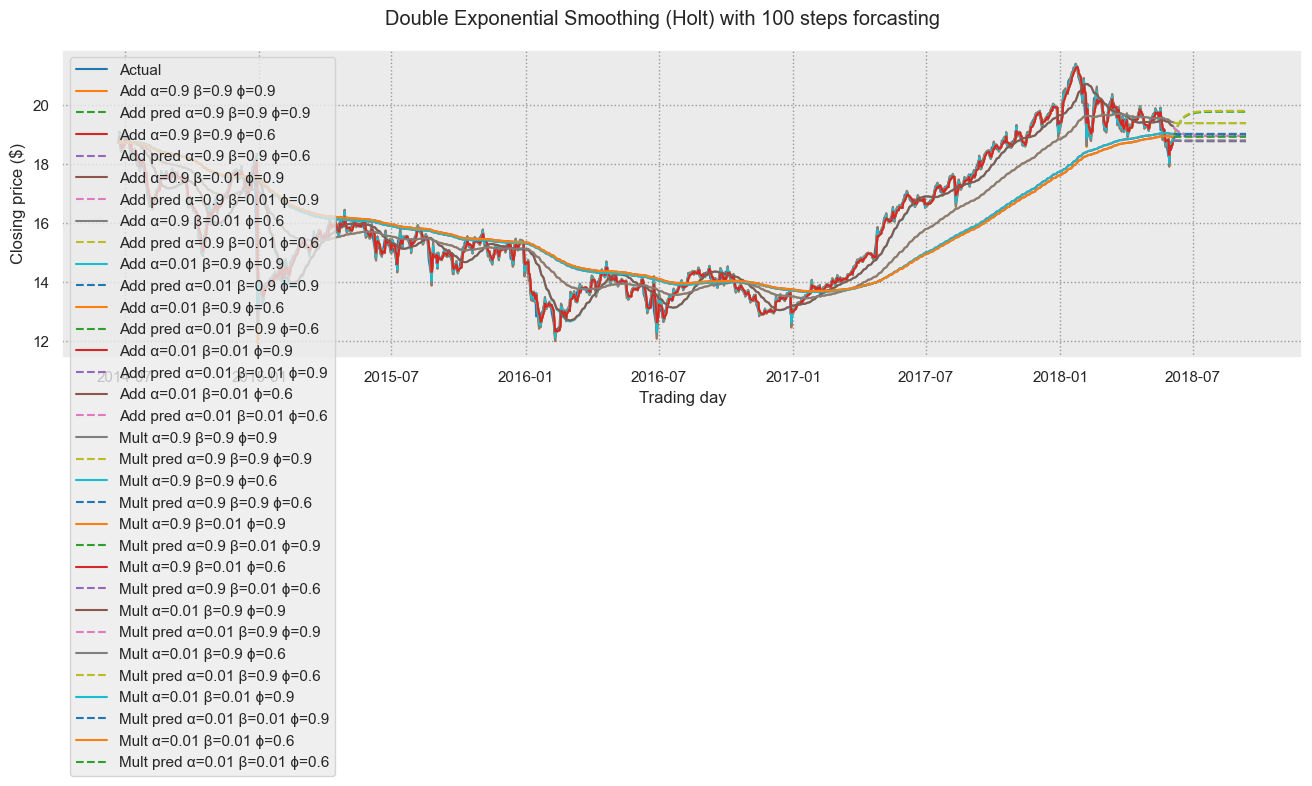

In [29]:
plot_double_exponential_smoothing(series, xlabel, ylabel, [0.9, 0.01], [0.9, 0.01], [], True, True, 100, plot_fig_args)
plot_double_exponential_smoothing(series, xlabel, ylabel, [0.9, 0.01], [0.9, 0.01], [0.9, 0.6], True, True, 100, plot_fig_args)

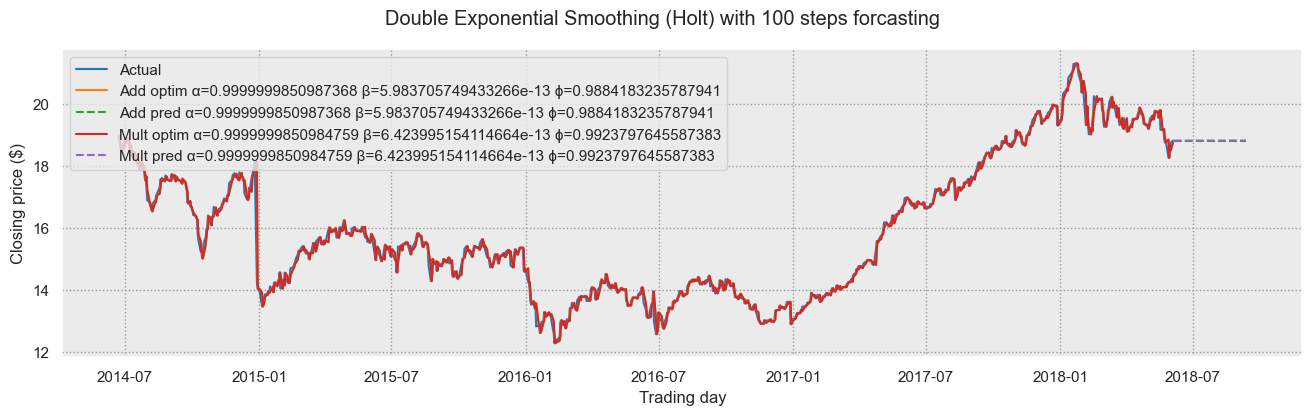

In [30]:
plot_double_exponential_smoothing(series, xlabel, ylabel, [], [], [], True, True, 100, plot_fig_args=plot_fig_args)

#### Tirple Exponential Smoothing (Holt Winters method)

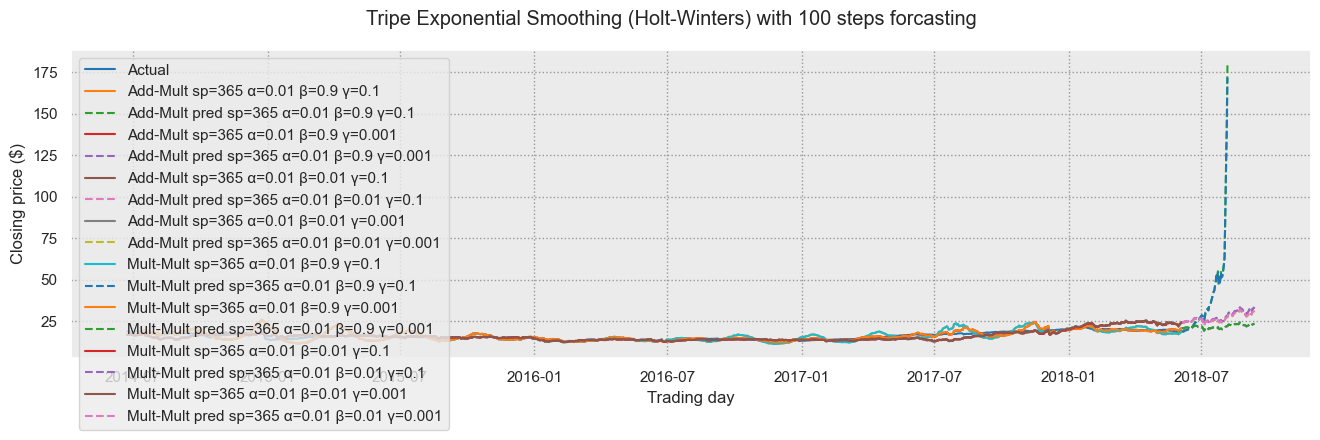

In [31]:
plot_triple_exponential_smoothing(series, xlabel, ylabel, [365], [0.01], [0.9, 0.01], [0.1,0.001], [], True, True, False, True, True, 100, plot_fig_args=plot_fig_args)

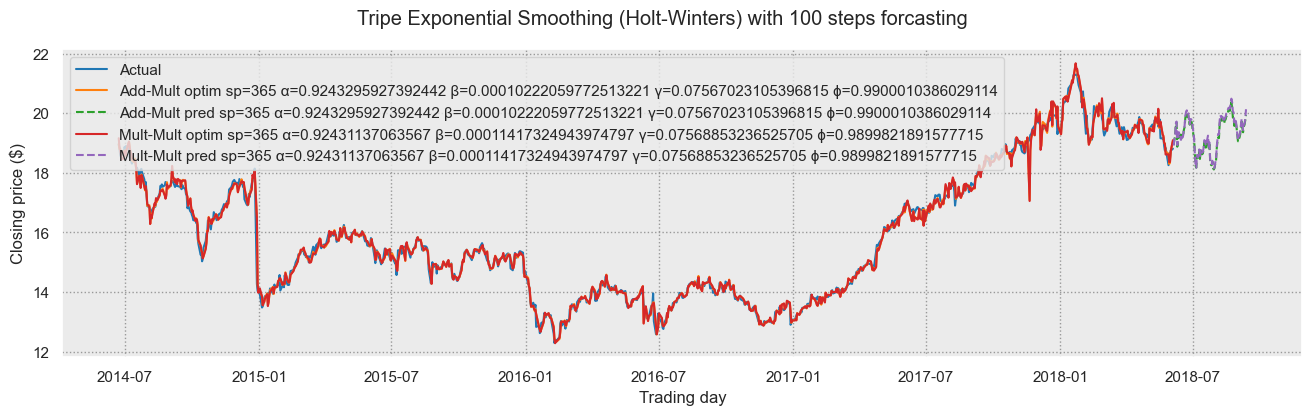

In [32]:
plot_triple_exponential_smoothing(series, xlabel, ylabel, [365], [], [], [], [], True, True, False, True, True, 100, plot_fig_args=plot_fig_args)

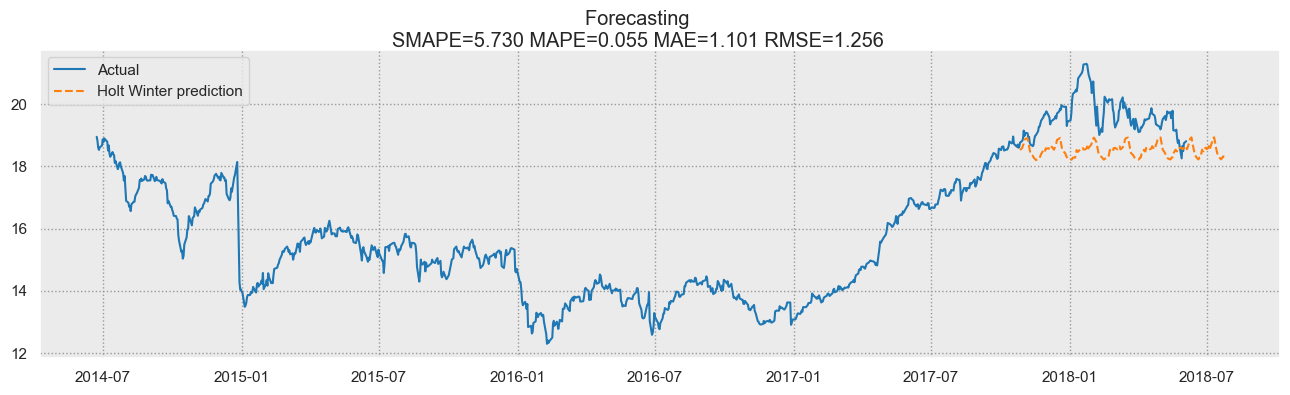

In [33]:
in_sample_size = 150
out_sample_size = 50
predictions_holt_winter=triple_exponential_smoothing(series[:-in_sample_size], 30, None, None, None, None, True, False, True, in_sample_size+out_sample_size)['forecasted_values']
plot_forecast(series, predictions_holt_winter, in_sample_size,'Holt Winter',error_name=['SMAPE', 'MAPE', 'MAE', 'RMSE'], error_callback=[symmetric_mean_absolute_percentage_error, mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error],plot_fig_args=plot_fig_args)

## Auto (S)ARIMA

In [34]:
# df = datasets.load_wineind()
# df = pd.Series(df, index=data.index[:len(df)]).sort_index()
# # plt.plot(df)
# series = df
series = data.CLOSE.sort_index()

In [35]:
n_splits = 5
gap = 10
train_size = int(.8*len(series))
# validation_size = int(.1*len(series))
test_size =  len(series)-train_size# int(.1*len(series))

# scoring = 'neg_root_mean_squared_error'
scoring = symmetric_mean_absolute_percentage_error

In [36]:
P = range(1,5)
D = [1]
Q = range(1,5)

order=list(product(P,D,Q))
order=order[0]

### Basic Auto ARIMA

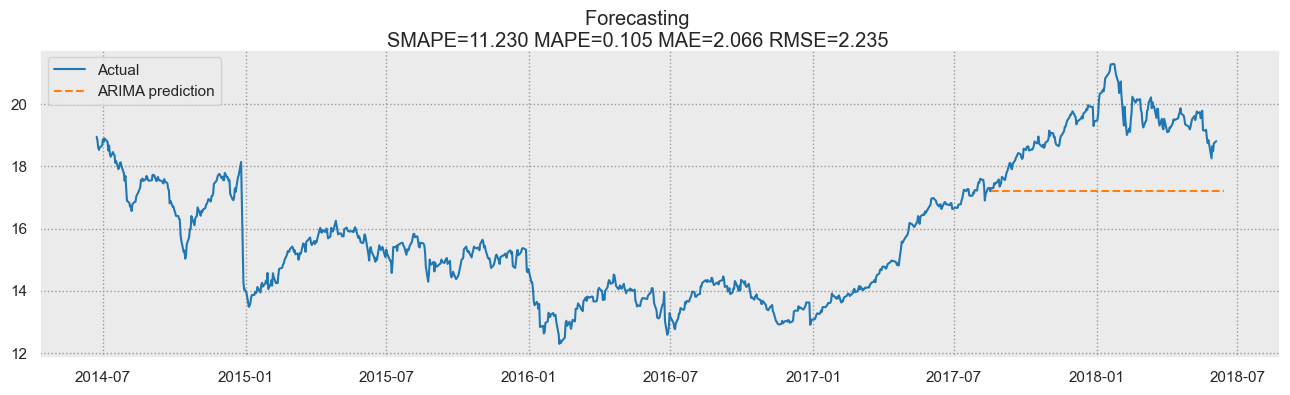

In [37]:
# Fit your model
train_set = series[:train_size]
test_set = series[train_size:]

arima = auto_arima(train_set)

# make your forecasts
predictions_arima = arima.predict(test_size+10)  # predict N steps into the future
plot_forecast(series, predictions_arima, test_size,'ARIMA',error_name=['SMAPE', 'MAPE', 'MAE', 'RMSE'], error_callback=[symmetric_mean_absolute_percentage_error, mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error],plot_fig_args=plot_fig_args)

### Cross-Validated Auto ARIMA

In [38]:
arima_cv = AutoARIMA(start_p=1, d=1, start_q=1, information_criterion='bic')
cv = model_selection.SlidingWindowForecastCV(h=test_size//2, step=gap, window_size=train_size)

In [39]:
# model_cv_scores = model_selection.cross_val_score(
#     model, series[:-test_size], scoring='smape', cv=cv, verbose=3)

# print("Model  CV scores: {}".format(model_cv_scores.tolist()))

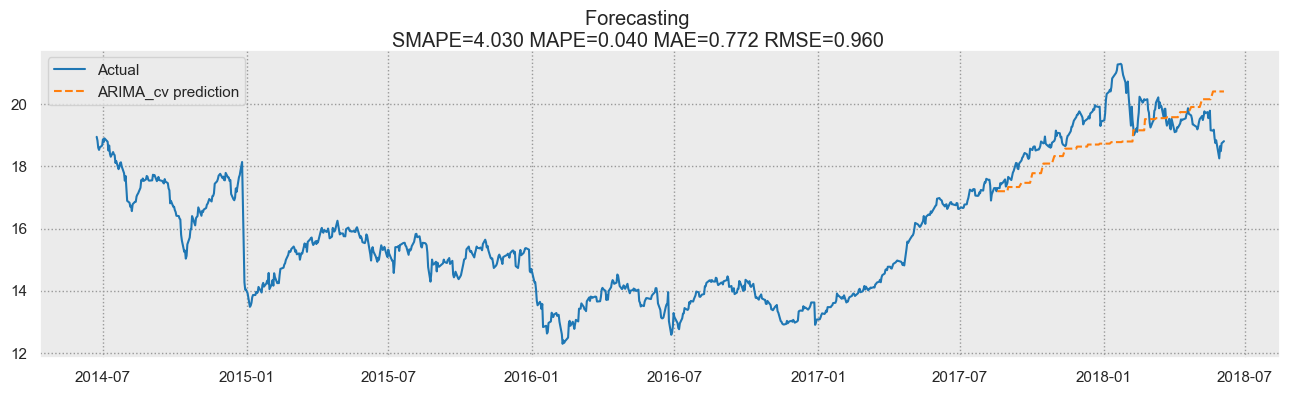

In [40]:
predictions_arima_cv = model_selection.cross_val_predict(arima_cv, series, cv=cv, verbose=1, averaging="median")
plot_forecast(series, predictions_arima_cv, len(predictions_arima_cv),'ARIMA_cv',error_name=['SMAPE', 'MAPE', 'MAE', 'RMSE'], error_callback=[symmetric_mean_absolute_percentage_error, mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error],plot_fig_args=plot_fig_args)

## Comparaison

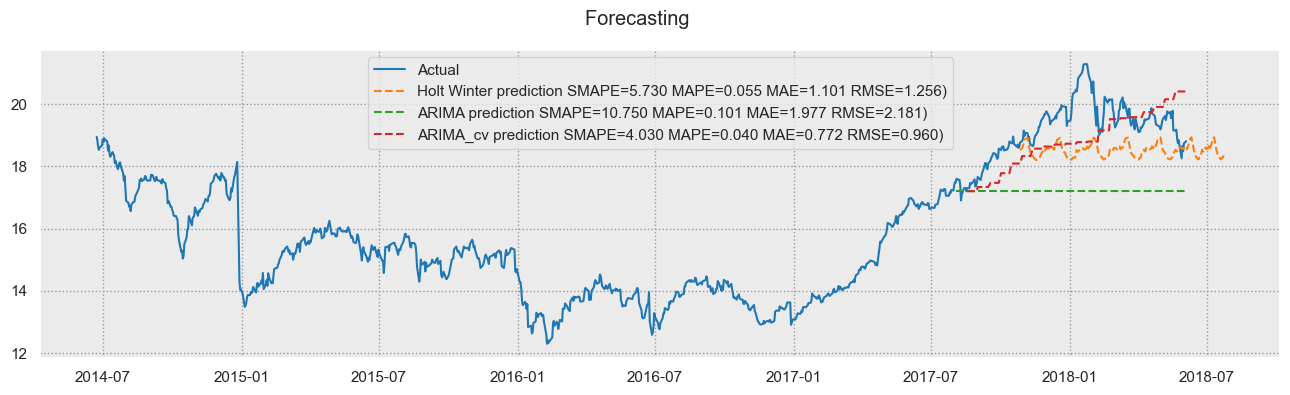

In [41]:
plot_multi_forecast(series, [predictions_holt_winter, predictions_arima, predictions_arima_cv], [in_sample_size, len(predictions_arima), len(predictions_arima_cv)],['Holt Winter', 'ARIMA', 'ARIMA_cv'],error_name=['SMAPE', 'MAPE', 'MAE', 'RMSE'], error_callback=[symmetric_mean_absolute_percentage_error, mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error],plot_fig_args=plot_fig_args)

In [42]:
# model = AutoARIMA()

# param_search = {'information_criterion' : ['aic', 'bic']}

# cv = MonteCarloCV(n_splits=n_splits, gap=gap, train_size=train_size, test_size=validation_size)

# gsearch = GridSearchCV(estimator=model, cv=cv, param_grid=param_search, scoring=scoring, n_jobs=-1)
# gsearch.fit(series, series)
# gsearch.best_estimator_.summary()

# Machine learning Modeling

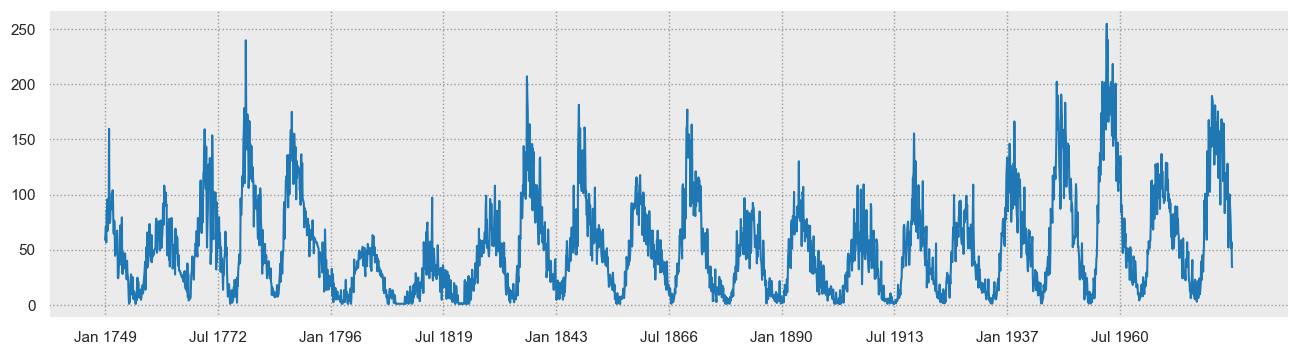

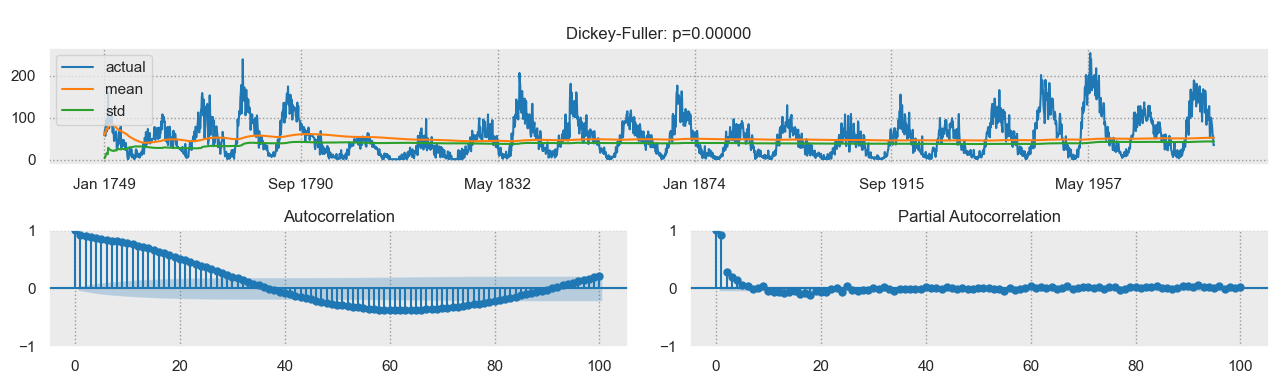

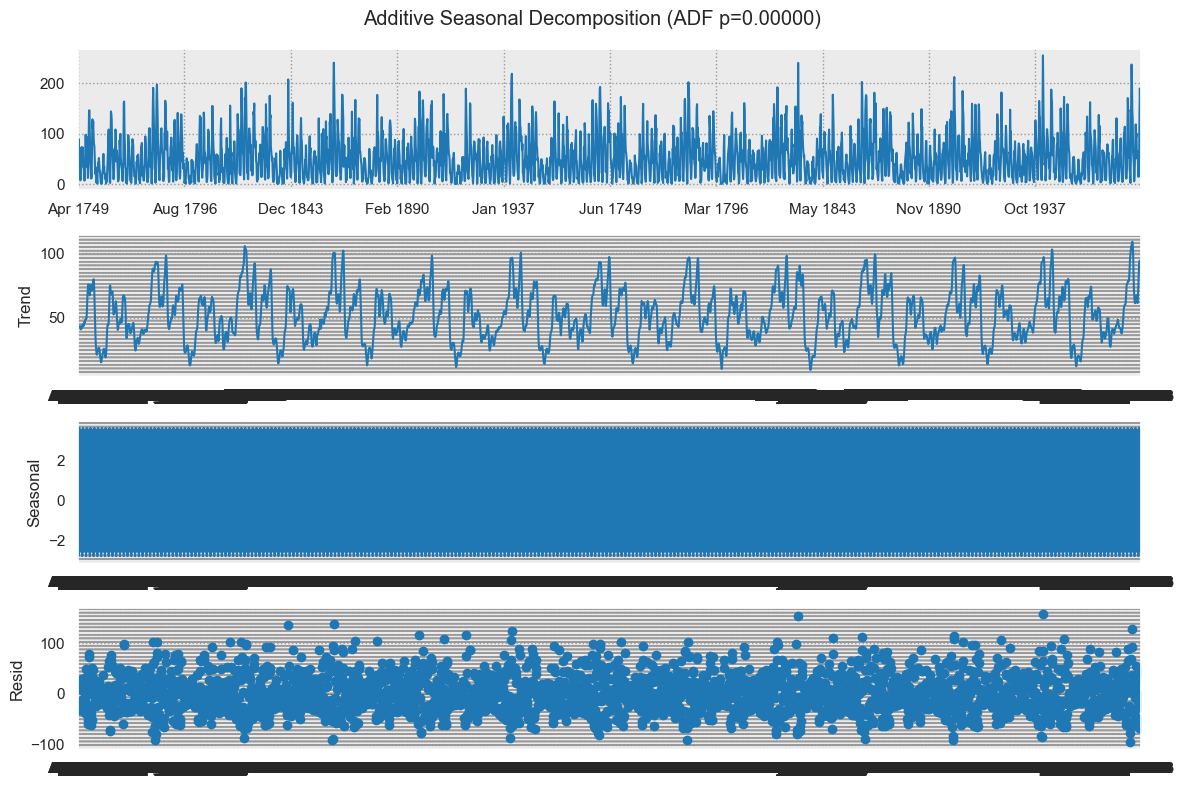

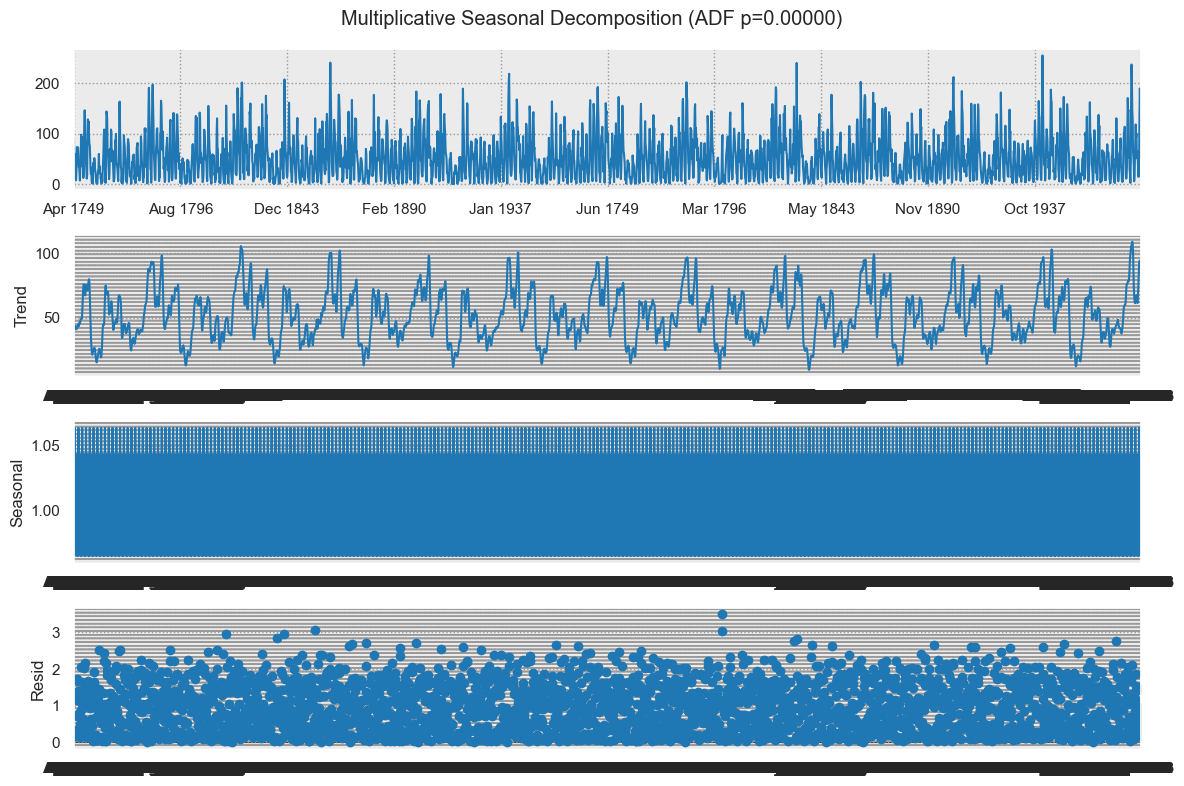

In [43]:
# loading the sunspots time series
# taking first differences to stabilize the mean
data = datasets.load_sunspots(as_series=True)
series=data+1 #to avoid 0 values
# series = data.diff()

lineplot(series, plot_fig_args=plot_fig_args, ticks=10)
plot_tsa(series, lags=100, sort_by_index=False)
plot_seasonal_decompose(series, 'add',10, ticks=10, plot_fig_args=plot_tsa_fig_args)
plot_seasonal_decompose(series, 'multi',10, ticks=10, plot_fig_args=plot_tsa_fig_args)

In [44]:
n_splits = 5
gap = 3
train_size = .7 #int(.7*len(series))
validation_size = .1 #int(.1*len(series))
test_size = .1 #int(.1*len(series)) # len(series)-(train_size+validation_size)

# scoring = 'neg_root_mean_squared_error'
scoring = root_mean_squared_error#symmetric_mean_absolute_percentage_error

## Time Delay Embedding (AR)

In [45]:
# applying time delay embedding
# using 3 lags (n_lags=3) to predict the next value (horizon=1)
n_lags=3
ts = time_delay_embedding(series=series, n_lags=n_lags, horizon=10)
display(ts)

X = ts.iloc[:, :n_lags]
y = ts.iloc[:, n_lags]

# train/test split
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=validation_size, shuffle=False)

display(X_tr)

Series(t-2)  Series(t-1)  Series(t-0)  Series(t+1)  Series(t+2)  \
Apr 1749         59.0         63.6         71.0         56.7         86.0   
May 1749         63.6         71.0         56.7         86.0         84.5   
Jun 1749         71.0         56.7         86.0         84.5         95.8   
Jul 1749         56.7         86.0         84.5         95.8         67.3   
Aug 1749         86.0         84.5         95.8         67.3         76.9   
...               ...          ...          ...          ...          ...   
Nov 1982        108.6        119.8         95.7         99.1        128.0   
Dec 1982        119.8         95.7         99.1        128.0         85.3   
Jan 1983         95.7         99.1        128.0         85.3         52.0   
Feb 1983         99.1        128.0         85.3         52.0         67.5   
Mar 1983        128.0         85.3         52.0         67.5         81.7   

          Series(t+3)  Series(t+4)  Series(t+5)  Series(t+6)  Series(t+7)  \
Apr 1749         84.5         95.8         67.3         76.9         76.5   
May 1749         95.8         67.3         76.9         76.5        159.6   
Jun 1749         67.3         76.9         76.5        159.6         86.2   
Jul 1749         76.9         76.5        159.6         86.2         74.3   
Aug 1749         76.5        159.6         86.2         74.3         76.9   
...               ...          ...          ...          ...          ...   
Nov 1982         85.3         52.0         67.5         81.7        100.2   
Dec 1982         52.0         67.5         81.7        100.2         92.1   
Jan 1983         67.5         81.7        100.2         92.1         83.2   
Feb 1983         81.7        100.2         92.1         83.2         72.8   
Mar 1983        100.2         92.1         83.2         72.8         51.3   

          Series(t+8)  Series(t+9)  Series(t+10)  
Apr 1749        159.6         86.2          74.3  
May 1749         86.2         74.3          76.9  
Jun 1749         74.3         76.9          90.2  
Jul 1749         76.9         90.2          89.3  
Aug 1749         90.2         89.3          91.0  
...               ...          ...           ...  
Nov 1982         92.1         83.2          72.8  
Dec 1982         83.2         72.8          51.3  
Jan 1983         72.8         51.3          56.8  
Feb 1983         51.3         56.8          34.3  
Mar 1983         56.8         34.3          34.4  

[2808 rows x 13 columns]

Series(t-2)  Series(t-1)  Series(t-0)
Apr 1749         59.0         63.6         71.0
May 1749         63.6         71.0         56.7
Jun 1749         71.0         56.7         86.0
Jul 1749         56.7         86.0         84.5
Aug 1749         86.0         84.5         95.8
...               ...          ...          ...
Jun 1959        186.7        164.3        173.0
Jul 1959        164.3        173.0        169.7
Aug 1959        173.0        169.7        150.6
Sep 1959        169.7        150.6        200.6
Oct 1959        150.6        200.6        146.2

[2527 rows x 3 columns]

### Random Forest Regressor (Cross-Validated)

In [46]:
# fitting a random forest
model = RandomForestRegressor(n_jobs=-1)

param_search = dict(bootstrap=[False, True], min_samples_split=list(range(2,11)), random_state=list(range(5)))

cv = MonteCarloCV(n_splits=n_splits, gap=gap, train_size=train_size, test_size=validation_size)

cv_search = GridSearchCV(estimator=model, cv=cv, param_grid=param_search, scoring=scoring, n_jobs=-1, verbose=2)
# cv_search = RandomizedSearchCV(estimator=model, cv=cv, param_distributions=param_search, scoring=scoring, n_jobs=-1, verbose=2)

cv_search.fit(X_tr, y_tr)
rfr_cv = cv_search.best_estimator_

# getting forecasts for the test set
predictions_rfr_cv = rfr_cv.predict(X_ts)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


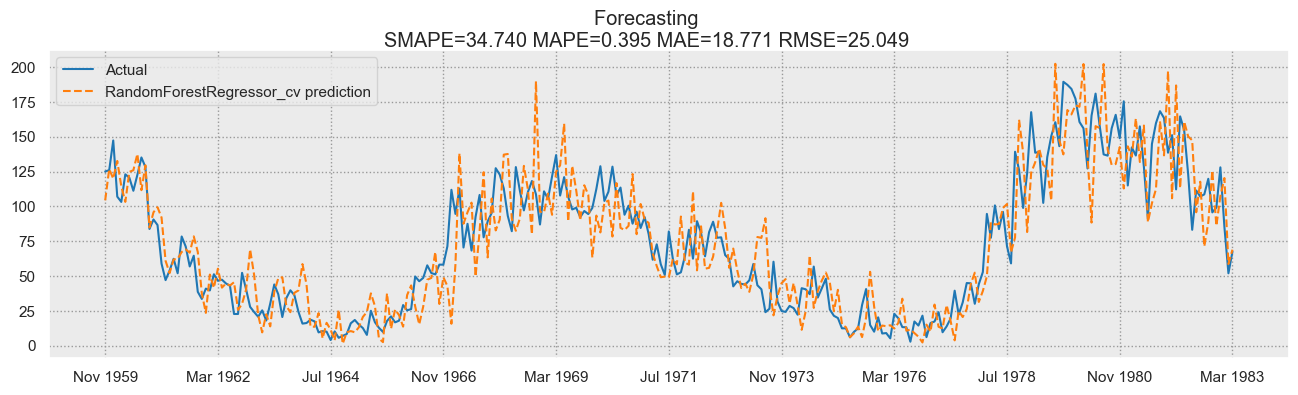

In [47]:
# plot forecast
plot_forecast(y_ts, predictions_rfr_cv, len(predictions_rfr_cv),'RandomForestRegressor_cv',error_name=['SMAPE', 'MAPE', 'MAE', 'RMSE'], error_callback=[symmetric_mean_absolute_percentage_error, mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error],plot_fig_args=plot_fig_args, ticks=10)

### LightGBM

In [48]:
# fitting a LightGBM
model = lgb.LGBMRegressor(n_jobs=-1)

param_search = dict(num_leaves=list(range(10,101)), random_state=list(range(10)))

cv = MonteCarloCV(n_splits=n_splits, gap=gap, train_size=train_size, test_size=validation_size)

cv_search = GridSearchCV(estimator=model, cv=cv, param_grid=param_search, scoring=scoring, n_jobs=-1, verbose=2)
# cv_search = RandomizedSearchCV(estimator=model, cv=cv, param_distributions=param_search, scoring=scoring, n_jobs=-1, verbose=2)

cv_search.fit(X_tr, y_tr)
lgbm_cv = cv_search.best_estimator_

# getting forecasts for the test set
predictions_lgbm_cv = lgbm_cv.predict(X_ts)

Fitting 5 folds for each of 910 candidates, totalling 4550 fits


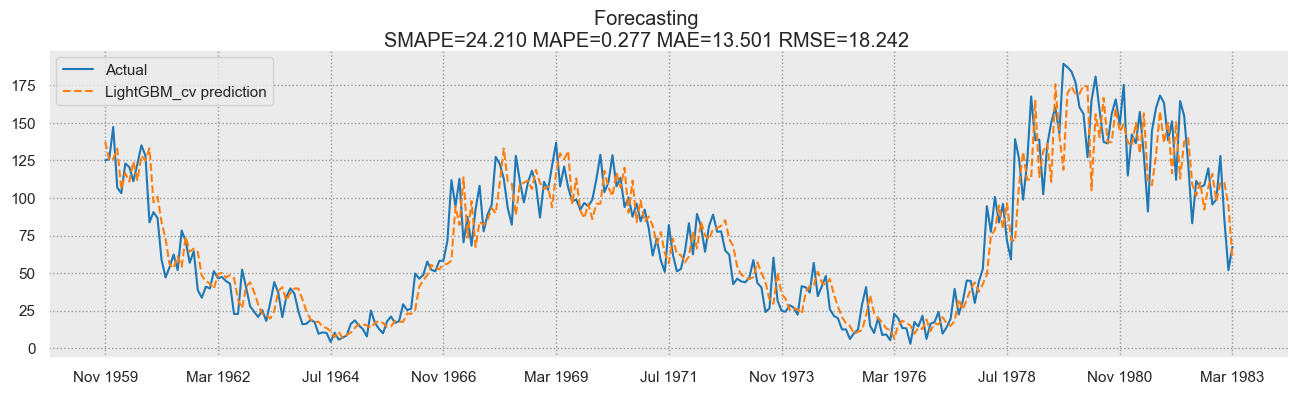

In [49]:
# plot forecast
plot_forecast(y_ts, predictions_lgbm_cv, len(predictions_lgbm_cv),'LightGBM_cv',error_name=['SMAPE', 'MAPE', 'MAE', 'RMSE'], error_callback=[symmetric_mean_absolute_percentage_error, mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error],plot_fig_args=plot_fig_args, ticks=10)

## Time Delay Embedding (AR) with Extra Features (mean, std)

In [50]:
# Add extra features
X_tr['mean'] = X_tr.mean(axis=1)
X_ts['mean'] = X_ts.mean(axis=1)

X_tr['std'] = X_tr.std(axis=1)
X_ts['std'] = X_ts.std(axis=1)

display(X_tr)

Series(t-2)  Series(t-1)  Series(t-0)        mean        std
Apr 1749         59.0         63.6         71.0   64.533333   4.943233
May 1749         63.6         71.0         56.7   63.766667   5.839140
Jun 1749         71.0         56.7         86.0   71.233333  11.962813
Jul 1749         56.7         86.0         84.5   75.733333  13.472523
Aug 1749         86.0         84.5         95.8   88.766667   5.010877
...               ...          ...          ...         ...        ...
Jun 1959        186.7        164.3        173.0  174.666667   9.220388
Jul 1959        164.3        173.0        169.7  169.000000   3.586084
Aug 1959        173.0        169.7        150.6  164.433333   9.873984
Sep 1959        169.7        150.6        200.6  173.633333  20.601025
Oct 1959        150.6        200.6        146.2  165.800000  24.672792

[2527 rows x 5 columns]

### Random Forest Regressor (Cross-Validated)

In [51]:
# fitting a random forest
model = RandomForestRegressor(n_jobs=-1)

param_search = dict(bootstrap=[False, True], min_samples_split=list(range(2,11)), random_state=list(range(5)))

cv = MonteCarloCV(n_splits=n_splits, gap=gap, train_size=train_size, test_size=validation_size)

cv_search = GridSearchCV(estimator=model, cv=cv, param_grid=param_search, scoring=scoring, n_jobs=-1, verbose=2)
# cv_search = RandomizedSearchCV(estimator=model, cv=cv, param_distributions=param_search, scoring=scoring, n_jobs=-1, verbose=2)

cv_search.fit(X_tr, y_tr)
rfr_extra_cv = cv_search.best_estimator_

# getting forecasts for the test set
predictions_rfr_extra_cv = rfr_extra_cv.predict(X_ts)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


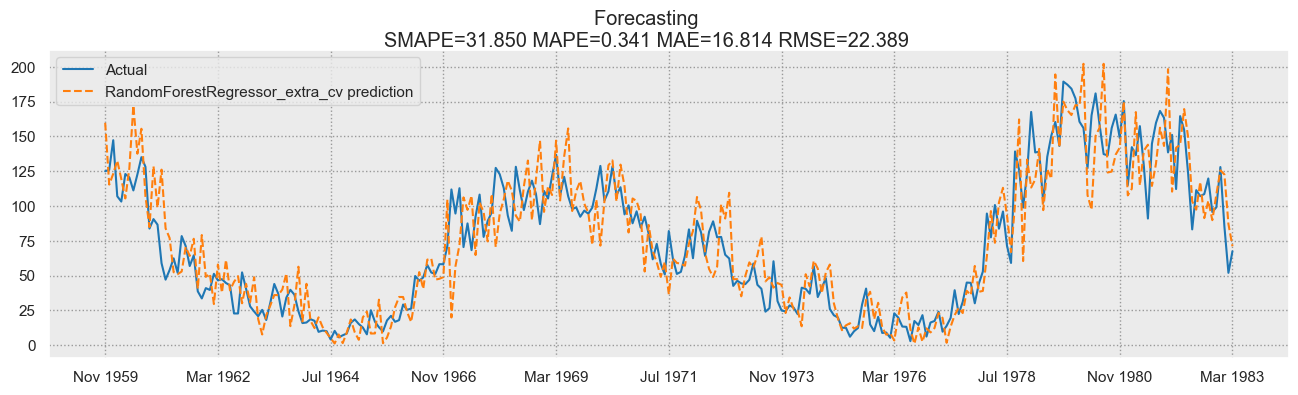

In [52]:
# plot forecast
plot_forecast(y_ts, predictions_rfr_extra_cv, len(predictions_rfr_extra_cv),'RandomForestRegressor_extra_cv',error_name=['SMAPE', 'MAPE', 'MAE', 'RMSE'], error_callback=[symmetric_mean_absolute_percentage_error, mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error],plot_fig_args=plot_fig_args, ticks=10)

### LightGBM

In [53]:
# fitting a random forest
model = lgb.LGBMRegressor(n_jobs=-1)

param_search = dict(num_leaves=list(range(10,101)), random_state=list(range(10)))

cv = MonteCarloCV(n_splits=n_splits, gap=gap, train_size=train_size, test_size=validation_size)

cv_search = GridSearchCV(estimator=model, cv=cv, param_grid=param_search, scoring=scoring, n_jobs=-1, verbose=2)
# cv_search = RandomizedSearchCV(estimator=model, cv=cv, param_distributions=param_search, scoring=scoring, n_jobs=-1, verbose=2)

cv_search.fit(X_tr, y_tr)
lgbm_extra_cv = cv_search.best_estimator_

# getting forecasts for the test set
predictions_lgbm_extra_cv = lgbm_extra_cv.predict(X_ts)

Fitting 5 folds for each of 910 candidates, totalling 4550 fits


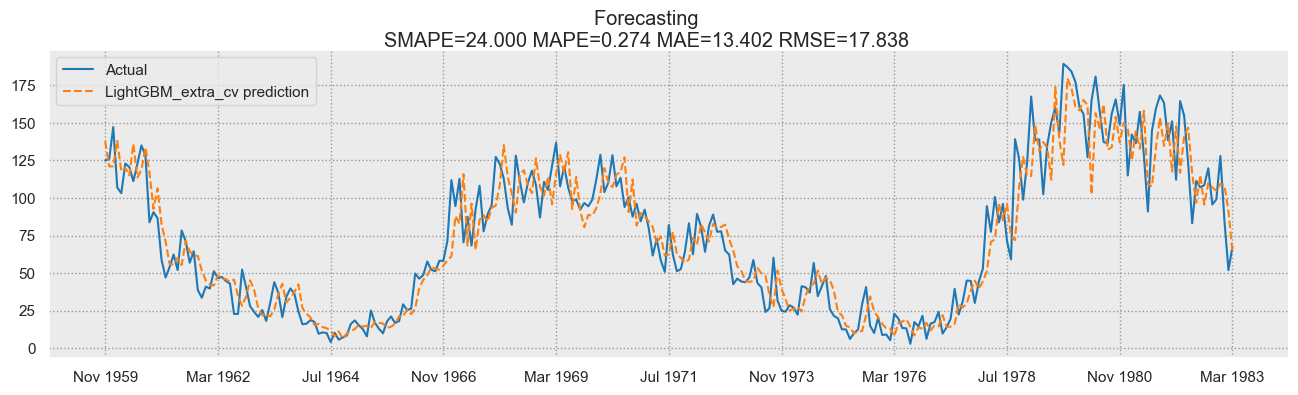

In [54]:
# plot forecast
plot_forecast(y_ts, predictions_lgbm_extra_cv, len(predictions_lgbm_extra_cv),'LightGBM_extra_cv',error_name=['SMAPE', 'MAPE', 'MAE', 'RMSE'], error_callback=[symmetric_mean_absolute_percentage_error, mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error],plot_fig_args=plot_fig_args, ticks=10)

## Comparaison

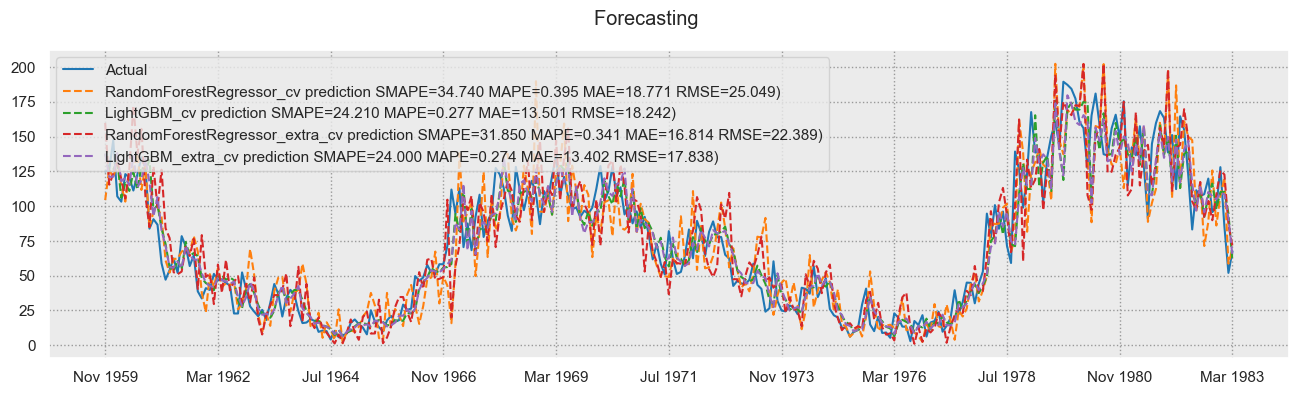

In [55]:
plot_multi_forecast(y_ts, [predictions_rfr_cv, predictions_lgbm_cv, predictions_rfr_extra_cv, predictions_lgbm_extra_cv], [len(predictions_rfr_cv),len(predictions_lgbm_cv), len(predictions_rfr_extra_cv),len(predictions_lgbm_extra_cv)],['RandomForestRegressor_cv','LightGBM_cv','RandomForestRegressor_extra_cv','LightGBM_extra_cv'],error_name=['SMAPE', 'MAPE', 'MAE', 'RMSE'], error_callback=[symmetric_mean_absolute_percentage_error, mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error],plot_fig_args=plot_fig_args, ticks=10)

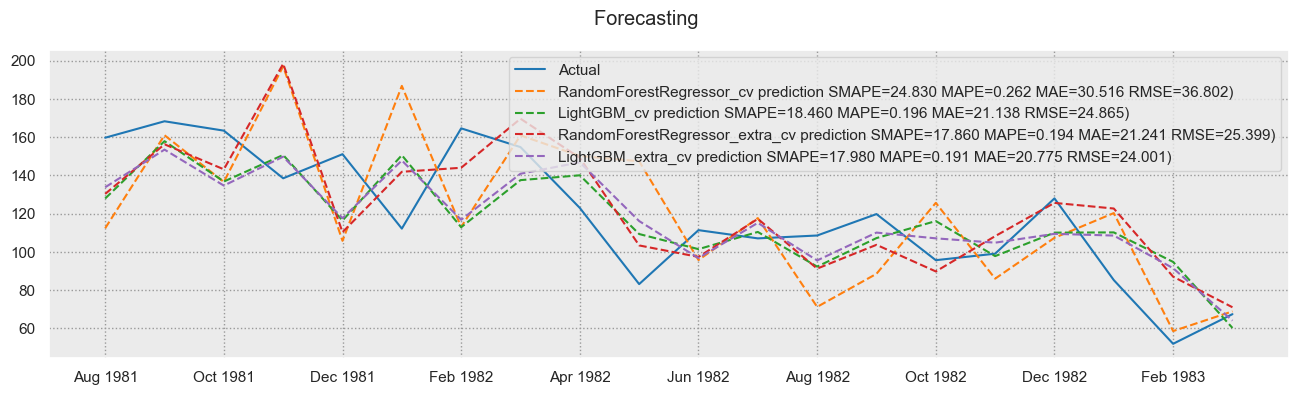

In [56]:
display_in_sample = 20
plot_multi_forecast(y_ts[-display_in_sample:], [predictions_rfr_cv[-display_in_sample:], predictions_lgbm_cv[-display_in_sample:], predictions_rfr_extra_cv[-display_in_sample:], predictions_lgbm_extra_cv[-display_in_sample:]], [len(predictions_rfr_cv),len(predictions_lgbm_cv), len(predictions_rfr_extra_cv),len(predictions_lgbm_extra_cv)],['RandomForestRegressor_cv','LightGBM_cv','RandomForestRegressor_extra_cv','LightGBM_extra_cv'],error_name=['SMAPE', 'MAPE', 'MAE', 'RMSE'], error_callback=[symmetric_mean_absolute_percentage_error, mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error],plot_fig_args=plot_fig_args, ticks=10)

# Deep Learning

Le data set contient :
	- 476 lignes et 1 colonnes.
	- 0 valeurs manquantes, ce qui représente 0.0 % du data set.


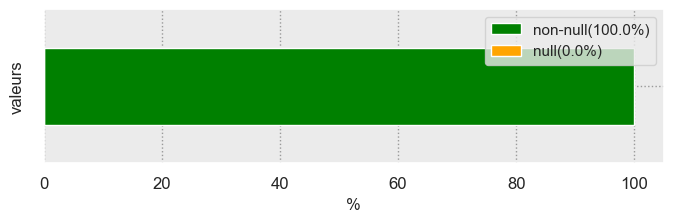

Monthly beer production
Month                           
1956-01                     93.2
1956-02                     96.0
1956-03                     95.2
1956-04                     77.1
1956-05                     70.9
...                          ...
1995-04                    127.0
1995-05                    151.0
1995-06                    130.0
1995-07                    119.0
1995-08                    153.0

[476 rows x 1 columns]

In [15]:
df = pd.read_csv('data/monthly-beer-production-in-austr.csv', index_col='Month')
verifier_taille(df)
df

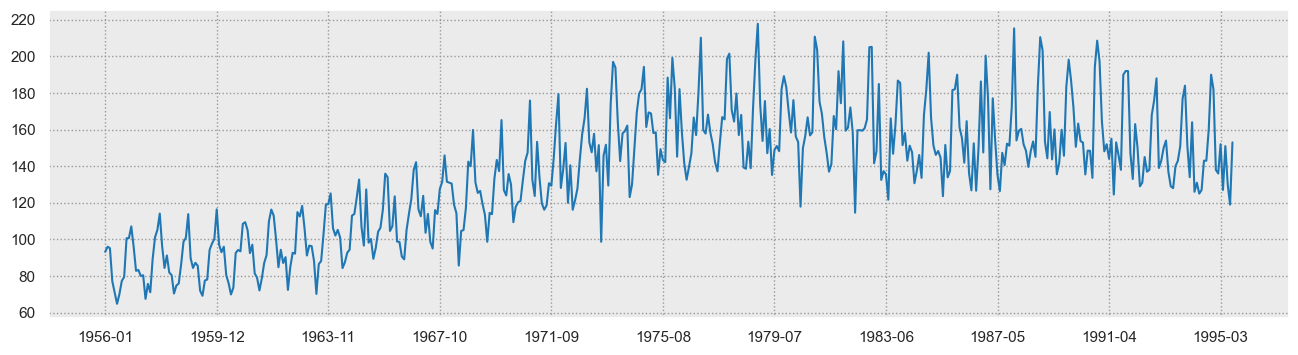

In [22]:
df.index.freq = 'MS'
lineplot(df, ticks=10, plot_fig_args=plot_fig_args)

In [17]:
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]

In [ ]:
train_data.values.tolist()

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data.values)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

## LSTM

In [24]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [25]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
452/452 [==============================] - 5s 7ms/step - loss: 0.0265
Epoch 2/20
452/452 [==============================] - 3s 7ms/step - loss: 0.0124
Epoch 3/20
452/452 [==============================] - 3s 6ms/step - loss: 0.0106
Epoch 4/20
452/452 [==============================] - 3s 7ms/step - loss: 0.0083
Epoch 5/20
452/452 [==============================] - 3s 6ms/step - loss: 0.0077
Epoch 6/20
452/452 [==============================] - 3s 7ms/step - loss: 0.0075
Epoch 7/20
452/452 [==============================] - 3s 7ms/step - loss: 0.0075
Epoch 8/20
452/452 [==============================] - 3s 7ms/step - loss: 0.0077
Epoch 9/20
452/452 [==============================] - 3s 7ms/step - loss: 0.0070
Epoch 10/20
452/452 [==============================] - 3s 7ms/step - loss: 0.0065
Epoch 11/20
452/452 [==============================] - 3s 7ms/step - loss: 0.0068
Epoch 12/20
452/452 [==============================] - 3s 6ms/step - loss: 0.0065
Epoch 13/20
452/452 [====

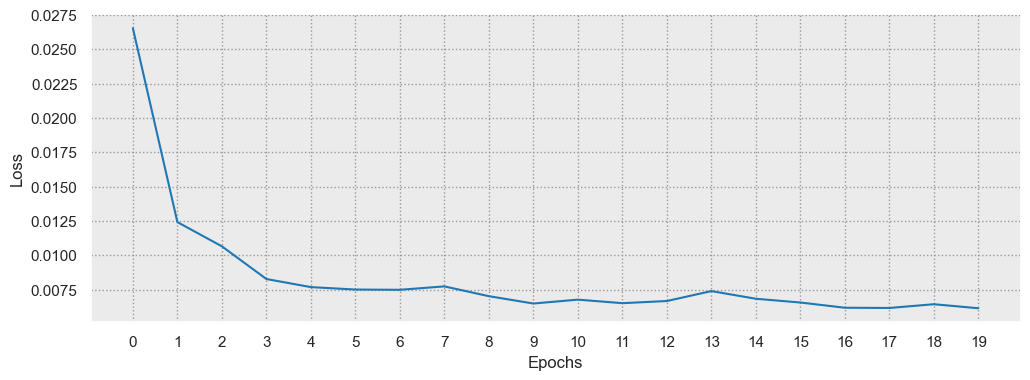

In [26]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm)

In [27]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 [==============================] - 0s 29ms/step


In [28]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
test_data['LSTM_Predictions'] = lstm_predictions
test_data

Monthly beer production  LSTM_Predictions
Month                                             
1994-09                    143.0        147.260758
1994-10                    160.0        160.257137
1994-11                    190.0        179.334816
1994-12                    182.0        180.364691
1995-01                    138.0        154.324303
1995-02                    136.0        149.371205
1995-03                    152.0        159.278358
1995-04                    127.0        136.188906
1995-05                    151.0        136.541102
1995-06                    130.0        133.011240
1995-07                    119.0        136.587703
1995-08                    153.0        145.947567

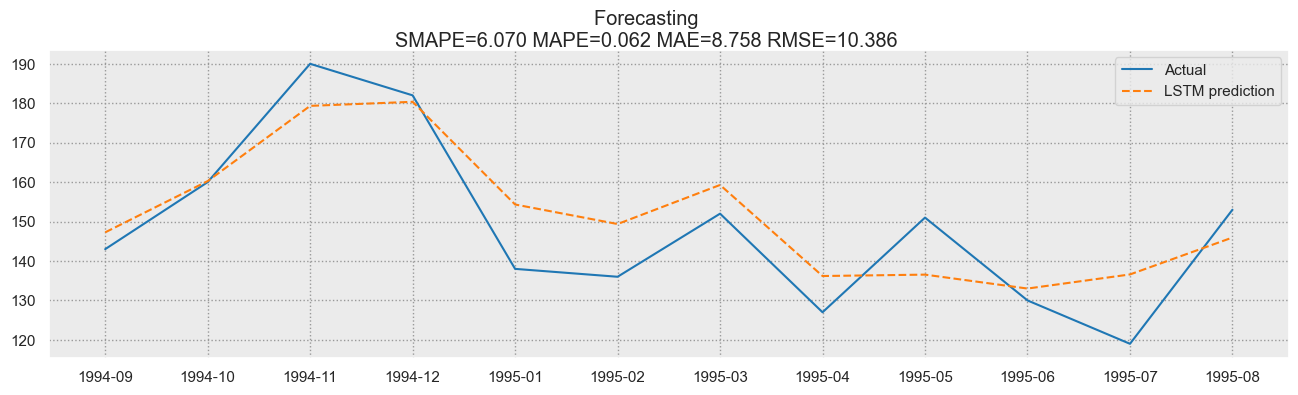

In [29]:
plot_forecast(test_data['Monthly beer production'], test_data['LSTM_Predictions'], len(test_data['LSTM_Predictions']),'LSTM',error_name=['SMAPE', 'MAPE', 'MAE', 'RMSE'], error_callback=[symmetric_mean_absolute_percentage_error, mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error],plot_fig_args=plot_fig_args, ticks=10)